# Introduction

This post is the second in a three-part series describing my attempt to identify “safe” and “unsafe” foods for Irritable Bowel Disease (IBD; including Ulcerative Colitis and Crohn’s Disease) using various machine learning techniques and Python. Part II below walks through the methodologies of the study, as well as selections of code. This project is ongoing, so the code and text below will reference future code and analysis that may not be complete. The working version is available at https://github.com/ZaxR/ibd_diet_analysis and a [reliable] working view of the jupyter notebook is available via [nbviewer](https://nbviewer.jupyter.org/github/zaxr/ibd_diet_analysis/blob/master/IBD%20Diet%20Analysis.ipynb).

To recap and expand upon the questions this analysis is trying to answer (from Part I):
* Are there any identifiable sub-clusters of diet among the survey participants?
* Are there relationships between individual foods or groups of foods? If so, can we
   * find common nutrient links between those foods? or
   * use that information to reduce the dimensionality of our features and improve our ability to predict food tolerance/intolerance?
* Are there any nutrients, vitamins, or minerals that impact food tolerance?
* Can food tolerance/intolerance be predicted with a reasonable degree of accuracy (ideally probability) for an IDB sufferer with only a few “known” safe/unsafe foods?

# Materials & Assumptions

### Materials: 

* The data reflects 670 survey responses from IBD sufferers (collected by [IBDrelief.com](https://www.ibdrelief.com/ "IBDrelief.com")) where they were asked for each of 250 foods to answer how well he/she tolerated the food. The [online] survey utilizes a sliding scale to accept answer inputs (see the survey [here](https://www.ibdrelief.com/surveys/diet "Diet Survey")), which are stored as integer values in a range from 0 through 10. A checkbox for each question gives the participant the option to not answer questions individually. The survey was developed and data has been provided by ibdrelief.com.
* Nutrient information for each surveyed food from the USDA’s database (provided for free via their API).
* Python 3.6.1, with apyori, numpy, pandas, [PyFIM](http://www.borgelt.net/pyfim.html) (used for fp-growth), scikit-learn, scipy, and sqlite libraries for data analysis and [graphviz](https://graphviz.readthedocs.io/en/stable/index.html), jupyter notebook, matplotlib, and seaborn for data visualization.

### Assumptions and Limitations:

* Given that the analysis is beginning from survey data about well/not-so-well tolerated foods, our implicit assumption is that food impacts symptoms of IBD. However, as discussed in part I, research has found no foods that are specifically linked to IBD symptoms to-date; and the role of food generally in causing and/or triggering flares of IBD is poorly understood. However, given anecdotal evidence and the strong belief in food-based symptom management by IBD patients, the results of this analysis remain relevant.
* That said, the quality of the survey data also has caveats, given that data (survey responses) is provided on a [self-reported basis](https://en.wikipedia.org/wiki/Self-report_study “Wikipedia link”) (e.g. participants’ responses are based on the limited knowledge/not knowing what they can/can’t eat and to what degree); potentially has other survey-design-based biases (e.g. [response biases](https://en.wikipedia.org/wiki/Response_bias “Wikipedia link”) such as [extreme responding bias](https://en.wikipedia.org/wiki/Response_bias#Extreme_responding “Wikipedia link”) and [sampling bias](https://en.wikipedia.org/wiki/Sampling_bias “Wikipedia link”)); and is subject to a number of other potential [cognitive biases](https://en.wikipedia.org/wiki/List_of_cognitive_biases “Wikipedia link”) (e.g. [illusory truth effect](https://en.wikipedia.org/wiki/Illusory_truth_effect “Wikipedia link”)).
* Lastly, the data set itself is very limited, with at most 570 usable surveys, only 19 of which are complete for all 250 foods (details in the data munging section below).

# IBD Survey Data Import, Munging and Initial Exploration

We'll begin by importing our first set of libraries, initialize our databse (commented out in the code, since we've already run it and only need to do so once), import our data, and validate that it has pulled correctly:

In [1]:
from IPython.display import display, display_html, Image
import numpy as np
import pandas as pd
import scipy
import sqlite3

import graphviz as gv
import matplotlib.pyplot as plt
import seaborn as sns


# create the database and tables, and import data
# %run db_builder.py

query = """SELECT uf.user_id, foods.name, uf.prep_id, uf.rating, uf.unknown
FROM users_to_foods uf, foods
WHERE uf.food_id = foods.id"""

# import data
conn = sqlite3.connect('food_db.db')
df = pd.read_sql(query, conn)

# default formatting for values
# pd.options.display.float_format = '{:,.0f}'.format
# pd.reset_option("^display")

def display_side_by_side(*args):
    # displays dfs side-by-side
    html_str=''
    for df in args:
        try:
            html_str+=df.to_html()
        except AttributeError:
            df2= pd.DataFrame(df)
            html_str+=df2.to_html()
    display_html(html_str.replace('table','table style="display:inline; padding: 10px"'),raw=True)  

# confirm the number or rows (questions presented to users, in total) 
'Number of questions presented to users: {0}'.format(df.shape[0])

'Number of questions presented to users: 151899'

In [2]:
# confirm columns were pulled correctly
df.columns

Index(['user_id', 'name', 'prep_id', 'rating', 'unknown'], dtype='object')

With the data in a dataframe, we can pivot the data so each row represents a person's survey answers and we can see the number of participants. However, pivoting initially failed with coulmn set to 'name', since two names weren't unique. 'Pumpkin' was used for both pumpkin as a vegetable and pumpkin seed. 'Squash' was similarly used to reflect both the vegetable and the drink. We manually adjusted the names (to 'Pumpkin seed' and 'Squash (drink)', respectively) to prevent confusion and allow the intended pivot without accidentally aggregating answers to very different survey questions, and then pivoted:

In [3]:
df_pivot = df.pivot(index='user_id', columns='name')
df_pivot.tail()

prep_id                                                       \
name    Agave Nectar Almond Almond Milk Anchovy Apple Apple Juice Apricot   
user_id                                                                     
3547             NaN    NaN         0.0     0.0   NaN         NaN     NaN   
3558             0.0    0.0         0.0     0.0   0.0         0.0     0.0   
3559             0.0    0.0         0.0     0.0   0.0         0.0     0.0   
3563             0.0    0.0         0.0     0.0   0.0         0.0     0.0   
3566             0.0    0.0         0.0     0.0   0.0         0.0     0.0   

                                             ...          unknown             \
name    Artichokes Asparagus Aspartame       ...       Watercress Watermelon   
user_id                                      ...                               
3547           NaN       NaN       NaN       ...              NaN        NaN   
3558           0.0       0.0       0.0       ...              0.0        0.0   
3559           0.0       0.0       0.0       ...              1.0        0.0   
3563           0.0       0.0       0.0       ...              1.0        0.0   
3566           0.0       0.0       0.0       ...              1.0        0.0   

                                                               \
name    Wheat Whiskey Wine - Champagne Wine - Pink Wine - Red   
user_id                                                         
3547      0.0     NaN              NaN         NaN        NaN   
3558      0.0     0.0              0.0         0.0        0.0   
3559      1.0     1.0              0.0         0.0        1.0   
3563      0.0     0.0              0.0         0.0        0.0   
3566      0.0     0.0              0.0         0.0        0.0   

                                                       
name    Wine - Sparkling Wine - White Yoghurt - Plain  
user_id                                                
3547                 NaN          NaN             0.0  
3558                 0.0          0.0             0.0  
3559                 0.0          0.0             0.0  
3563                 0.0          0.0             0.0  
3566                 0.0          0.0             0.0  

[5 rows x 750 columns]

Some NaNs (missing values) already appear in the table, which most likely means that not all food questions were asked for all surveys. Our supposition is that there were multiple iterations of the survey all stored in the data table without a column to label the survey number. Let's see how many surveys there were and what the size of each survey was:

In [4]:
q_count = {}
for i in df_pivot.isnull().sum(axis=1).sort_values(ascending=False):
    key = str(int((df_pivot.shape[1] - i)/3)) + '-question'  # divide by 3 to reflect the # of hierarchically indexed columns
    if key in q_count:
        q_count[key] += 1
    else:
        q_count[key] = 1

for k, v in q_count.items():
    print (k,'survey count: ', v)

40-question survey count:  29
61-question survey count:  14
80-question survey count:  24
125-question survey count:  8
164-question survey count:  16
199-question survey count:  8
249-question survey count:  1
250-question survey count:  570


We may still be able to use all of the data from the various iterations of the survey for analysis not sensitive to missing values, but for now we will limit our core data set to only the latest 250-question version of the exam, which leaves ~85% of the initial surveys (570/670).

In [5]:
df_old_surveys = df_pivot.loc[pd.isnull(df_pivot).any(1),:]
print('Confirmed number of old surveys, which are excluded (and saved for later): {0}'.format(df_old_surveys.shape[0]))
df_new_surveys = df_pivot.dropna()
print('Confirmed number of new surveys, which are included: {0}'.format(df_new_surveys.shape[0]))
df_new_surveys.tail()

Confirmed number of old surveys, which are excluded (and saved for later): 100
Confirmed number of new surveys, which are included: 570


prep_id                                                       \
name    Agave Nectar Almond Almond Milk Anchovy Apple Apple Juice Apricot   
user_id                                                                     
3544             0.0    0.0         0.0     0.0   0.0         0.0     0.0   
3558             0.0    0.0         0.0     0.0   0.0         0.0     0.0   
3559             0.0    0.0         0.0     0.0   0.0         0.0     0.0   
3563             0.0    0.0         0.0     0.0   0.0         0.0     0.0   
3566             0.0    0.0         0.0     0.0   0.0         0.0     0.0   

                                             ...          unknown             \
name    Artichokes Asparagus Aspartame       ...       Watercress Watermelon   
user_id                                      ...                               
3544           0.0       0.0       0.0       ...              0.0        0.0   
3558           0.0       0.0       0.0       ...              0.0        0.0   
3559           0.0       0.0       0.0       ...              1.0        0.0   
3563           0.0       0.0       0.0       ...              1.0        0.0   
3566           0.0       0.0       0.0       ...              1.0        0.0   

                                                               \
name    Wheat Whiskey Wine - Champagne Wine - Pink Wine - Red   
user_id                                                         
3544      0.0     0.0              0.0         0.0        0.0   
3558      0.0     0.0              0.0         0.0        0.0   
3559      1.0     1.0              0.0         0.0        1.0   
3563      0.0     0.0              0.0         0.0        0.0   
3566      0.0     0.0              0.0         0.0        0.0   

                                                       
name    Wine - Sparkling Wine - White Yoghurt - Plain  
user_id                                                
3544                 0.0          0.0             0.0  
3558                 0.0          0.0             0.0  
3559                 0.0          0.0             0.0  
3563                 0.0          0.0             0.0  
3566                 0.0          0.0             0.0  

[5 rows x 750 columns]

Surveys appear to have values of 0 for both a filled in answer of never being able to eat a food, and when the participant decided not to answer the question. We can remove questions that participants decided not to answer based on a 1 (True) value for the "unknown" column. ((This will result in NaN values in our dataframe.))

In [6]:
df_unpivot = df_new_surveys.stack().reset_index()
df_answered = df_unpivot[df_unpivot.unknown != 1 ]
df_answered_pivot = df_answered.pivot(index='user_id', columns='name', values='rating')
print('{0} questions weren\'t answered.'.format(int(df_answered_pivot.isnull().sum().sum())))
df_answered_pivot.tail()

53429 questions weren't answered.


name,Agave Nectar,Almond,Almond Milk,Anchovy,Apple,Apple Juice,Apricot,Artichokes,Asparagus,Aspartame,...,Watercress,Watermelon,Wheat,Whiskey,Wine - Champagne,Wine - Pink,Wine - Red,Wine - Sparkling,Wine - White,Yoghurt - Plain
user_id,,,,,,,,,,,,,,,,,,,,,
3544,NaN,10.0,NaN,10.0,4.0,0.0,5.0,10.0,10.0,NaN,...,10.0,10.0,2.0,9.0,2.0,1.0,2.0,1.0,0.0,10.0
3558,6.0,6.0,10.0,8.0,4.0,4.0,4.0,9.0,7.0,6.0,...,4.0,6.0,1.0,2.0,3.0,3.0,6.0,3.0,3.0,3.0
3559,NaN,10.0,NaN,NaN,10.0,0.0,NaN,7.0,7.0,4.0,...,NaN,9.0,NaN,NaN,5.0,6.0,NaN,6.0,7.0,9.0
3563,NaN,7.0,7.0,NaN,6.0,NaN,NaN,NaN,6.0,NaN,...,NaN,7.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
3566,NaN,NaN,NaN,NaN,5.0,NaN,6.0,NaN,NaN,NaN,...,NaN,10.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0


That's a really high number of questions that weren't answered. Let's dig into which questions went unanswered the most:

In [7]:
# counts of unanswered question by food, sorted most to least
# can compare the % answered from the new and old surveys to help improve the survey responses
possible_to_answer = df_answered_pivot.shape[0]
unanswered_count = df_answered_pivot.isnull().sum().sort_values(ascending=False)
unanswered_percent = unanswered_count.divide(possible_to_answer)*100
unanswered = pd.DataFrame({'unanswered_count': unanswered_count, 'unanswered_percent': unanswered_percent})
unanswered['unanswered_percent'] = unanswered['unanswered_percent'].map('{:,.2f}%'.format)

display_side_by_side(unanswered.head(10), unanswered.tail(10).sort_values('unanswered_percent'))

,unanswered_count,unanswered_percent
name,,
Goose Egg,486,85.26%
Quail Egg,470,82.46%
Rabbit,462,81.05%
Goose,445,78.07%
Herring,442,77.54%
Veal,439,77.02%
Hazelnut Milk,437,76.67%
Rice Milk,436,76.49%
Oysters,434,76.14%


The least answered survey questions (left table above) seem to be less commonly eaten foods, such as goose eggs and quail eggs, which makes sense - users can't answer if they can eat a food if they haven't tried it before. Conversely, and supporting that conclusion, the most answered survey questions (right table above) all seem to be more common foods (however, of note, there is no question that was answered by everyone). It also makes sense in the context of the number of question responses on surveys, with the average person only answering 156/250 (62%) of the questions (and only 19 answering all 250):

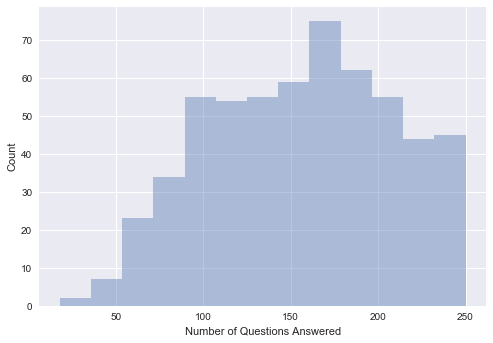

count    570.00
mean     156.26
std       52.75
min       18.00
25%      118.00
50%      158.50
75%      197.00
max      250.00
dtype: object

In [8]:
num_answers_per_person = df_answered_pivot.count(axis=1)

# distribution of number of answers per survey
sns.distplot(num_answers_per_person.dropna(), kde=False)
plt.xlabel('Number of Questions Answered')
plt.ylabel('Count')
plt.show()

num_answers_per_person.describe().apply('{:,.2f}'.format)

So the remaining data points seem to accurately reflect our usable data set, but now the quality/usability of that data is called into doubt. Before we clean up the data further (decide how to handle NaNs), we need to assess what type of data we're working with (measurement scale), and as a result, the available/appropriate tests we'll be using the data for.

## Measurement Scale

Determining whether our survey results most appropriately reflect interval data (as it was collected) or [discrete] ordinal data (categorical data, where the values don't necessarily have equal "distance") is somewhat challenging in this case, and extremely important.  If we determine that our data is ordinal, parameters such as mean and standard deviation will likely be invalid, and any parametric analyses (generally considered to have more statistical power) based on the normal distribution will be impossible. Rather, rank, median, and range and associated tests (such as classification) will be the extent of our toolkit. The “intervalness” of the data is an attribute of the data, not of the labels.

The primary distinguishing factor will be whether the "distance" between responses is equal and meaningful. The edge cases in specific will be the determining factor: is the distance between 0 and 1 (never eat and very, very rarely eat) the same as 1 to 2 (very, very rarely eat to very rarely eat)? Unfortunately it seems logical that those distances are not the same (although survey partcipants may have mentally been assuming such equal increments in attempting to place the scale). You can eat "infinitely" more of a food at 1 than 0 (i.e. how can you even measure the distance from never to anything more than never?), bounded only by the normal quantities of food people can/want to eat. As a result of the fact that distances are inherently unequal, it would seem that the data should be treated as ordinal (and for testing purposes, therefore, largely categorical).

However the answer to this question is actually highly controvetial in the field of statistics, with Likert survey results (usually five or seven options, presented as variations on 'Always,' 'Sometimes,' 'Never') being the primary focus of that debate/research. The scope of the debate is beyond the pervue of this report (see select links below for more detail), but the ultimate "answer" to the debate is that in at least some cases (particularly when we have data collected from a label-less, continuous, sliding scale, as with our survey data; see sample image below), interval-type parametric analysis is robust enough with respect to violations of its core assumptions that it can appropriately be run on Likert-style survey data. As a result, we will cautiously attempt to analyze the data assuming interval measurement in some cases (understanding the limitations of mean and variance as descriptive statistics).

* [Analyzing and Interpreting Data From Likert-Type Scales](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3886444/)
* [Likert scales, levels of measurement and the "laws" of statistics](https://www.scribd.com/document/344028976/Likert-scales-levels-of-measurement-and-the-laws-of-statistics-pdf)
* [How to Use the Likert Scale in Statistical Analysis](https://statisticscafe.blogspot.it/2011/05/how-to-use-likert-scale-in-statistical.html?m=1)
* [Parametric tests and Likert Scales (Ordinal data) - Two different views](https://stats.stackexchange.com/questions/175848/parametric-tests-and-likert-scales-ordinal-data-two-different-views)

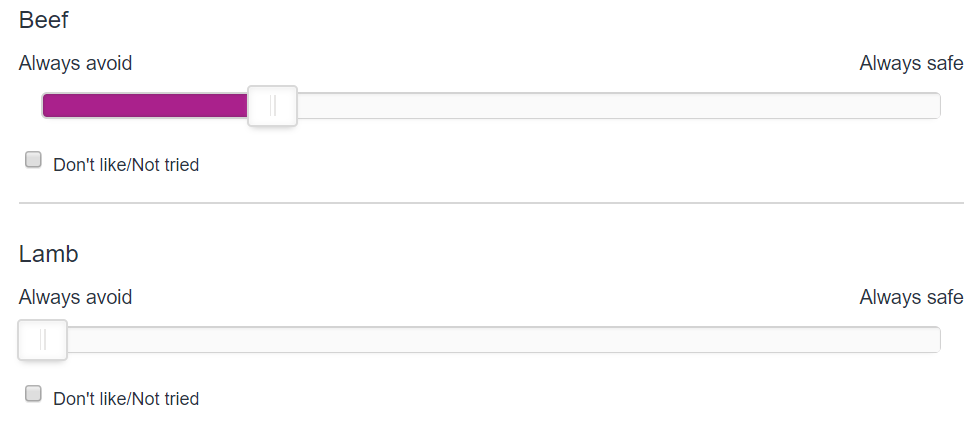

That said, and even assuming we have interval data, the facts that 1) the data was collected on a integer basis (as opposed to continuous) and 2) the probability distibutions of each of the food's responses are non-normal (and not normalizable without material and potentially biasing transformations) potentially severely limit the ability to utilize the more statistically powerful tests we'd hoped to be able to use anyway (e.g. regressions). See below for some of the supporting statistics:

In [9]:
question_answer_summary = df_answered_pivot.describe()
question_answer_summary.applymap('{:,.2f}'.format)

name,Agave Nectar,Almond,Almond Milk,Anchovy,Apple,Apple Juice,Apricot,Artichokes,Asparagus,Aspartame,...,Watercress,Watermelon,Wheat,Whiskey,Wine - Champagne,Wine - Pink,Wine - Red,Wine - Sparkling,Wine - White,Yoghurt - Plain
count,180.00,448.00,229.00,161.00,550.00,497.00,362.00,198.00,395.00,306.00,...,327.00,453.00,516.00,295.00,417.00,414.00,360.00,426.00,433.00,495.00
mean,3.23,4.08,6.99,4.97,5.39,4.68,4.24,3.71,5.80,2.73,...,5.17,6.28,4.02,2.25,3.43,3.37,2.96,3.29,3.59,5.80
std,4.21,3.94,3.85,4.37,3.84,4.02,3.84,3.98,3.88,3.53,...,4.05,3.86,3.61,3.48,3.67,3.66,3.62,3.57,3.63,3.97
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,5.00,0.00,2.00,0.00,0.00,0.00,2.00,0.00,...,0.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00
50%,0.00,4.00,10.00,5.00,5.00,5.00,4.00,2.00,6.00,1.00,...,5.00,7.00,4.00,0.00,2.00,2.00,1.00,2.00,3.00,6.00
75%,8.00,8.00,10.00,10.00,10.00,10.00,7.75,7.00,10.00,5.00,...,10.00,10.00,6.00,5.00,6.00,6.00,5.00,6.00,6.00,10.00
max,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,...,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00


In [10]:
# run tests for normality
tally = 0
for i in range(df_answered_pivot.shape[1]):
    statistic, p_val = scipy.stats.normaltest(df_answered_pivot.iloc[:,i], nan_policy='omit')
    if (p_val > 0.05 and statistic != '--'):  # low p-value indicates it's unlikely the data came from a normal distribution
        print(i, p_val, statistic)
        tally += 1

print('{0} normal distributions found.'.format(tally))
# ALSO use scipy.stats.shapiro shapiro-wilk test

C:\Anaconda\lib\site-packages\scipy\stats\mstats_basic.py:2254: RuntimeWarning: divide by zero encountered in true_divide
  term2 = ma.power((1-2.0/A)/denom,1/3.0)


0 normal distributions found.


None of our tests may be normal, but visualizing the counts for each score by food may be useful in finding other transformable distributions for more targeted analysis later:

In [11]:
# Responses by food and score
by_score = df_answered_pivot.apply(pd.Series.value_counts)
by_score

name,Agave Nectar,Almond,Almond Milk,Anchovy,Apple,Apple Juice,Apricot,Artichokes,Asparagus,Aspartame,...,Watercress,Watermelon,Wheat,Whiskey,Wine - Champagne,Wine - Pink,Wine - Red,Wine - Sparkling,Wine - White,Yoghurt - Plain
0.0,96,154,37,53,104,143,110,84,73,146,...,88,80,144,179,169,171,170,175,160,97
1.0,13,31,3,9,31,23,22,10,16,28,...,10,14,45,18,20,20,22,17,25,21
2.0,5,22,6,6,29,31,17,6,20,18,...,14,13,27,10,25,22,17,32,21,22
3.0,1,16,6,2,25,26,26,6,13,12,...,9,14,31,7,26,27,22,26,28,19
4.0,3,21,5,3,33,25,19,9,17,15,...,22,13,35,5,11,18,15,20,26,23
5.0,7,45,14,14,70,45,36,19,42,22,...,31,43,70,22,50,46,26,45,50,52
6.0,5,29,10,7,30,22,27,11,30,11,...,19,29,38,10,22,21,19,23,21,23
7.0,3,14,13,3,26,23,14,8,20,8,...,12,27,15,5,18,10,10,17,19,18
8.0,5,11,4,5,24,12,8,2,14,7,...,13,22,20,4,12,18,9,14,16,21
9.0,3,13,15,2,13,22,9,4,14,3,...,10,24,9,3,6,3,4,3,9,23


While reviewing the table, one seemingly odd discover was made - Peppers (Capsicum) and Peppers, Chili had very different distributions. This is interesting because Chili Peppers are a type of Capsicum pepper. We will come back to this in later analysis, and perhaps identify a a vitamin, mineral, or other chemical distrinction to explain the difference.

In [12]:
pd.concat([by_score['Peppers (Capsicum)'], by_score['Peppers, Chili']], axis=1)

,Peppers (Capsicum),"Peppers, Chili"
0.0,101,188
1.0,37,50
2.0,29,26
3.0,24,20
4.0,21,14
5.0,52,44
6.0,28,12
7.0,22,10
8.0,20,5
9.0,8,10


While our initial statistics may not be as useful as hoped, as long as we're looking at the data, there are a couple observations we can fairly make now: at first glance it seems like there are no universally tolerated/untolerated foods:

In [13]:
print('There are no foods that everyone could tolerate.' if question_answer_summary.loc['min'].max() == 0 else 'There ARE foods that everyone could tolerate.')
print('There are no foods that noone could tolerate.' if question_answer_summary.loc['max'].min() == 10 else 'There ARE foods that noone could tolerate.')

There are no foods that everyone could tolerate.
There are no foods that noone could tolerate.


And even on a global response-by-score basis, our probability distribution of responses to questions is non-normal (bimodal), with heavy spikes for responses of 0 and 10.

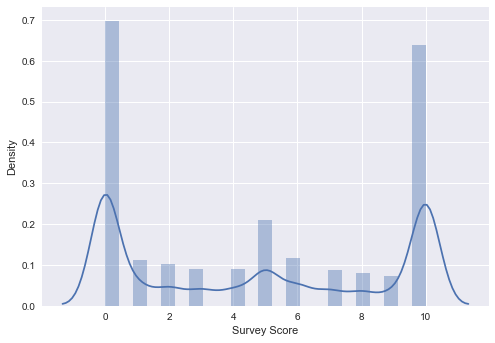

In [14]:
test_df = df_answered_pivot.stack().reset_index()
sns.distplot(test_df[0], norm_hist=True)
plt.xlabel('Survey Score')
plt.ylabel('Density')
plt.show()

# Table form of the histogram with absolute counts; not displayed
by_score_summary = by_score.sum(axis=1)

Lastly, and now that we've determined our data will be "cautiously"  interval (but otherwise ordinal), we can create subsets of our data where we drop missing data (as most, but not all, methods of analysis we'll be able to run have difficulty with missing data). However, given the sparcity of our data, that's not such an easy task. We've already established that not a single food had an answer given by every participant, and that only 19 people answered all 250 questions. What we're left with is a [multi-objective optimization problem](https://en.wikipedia.org/wiki/Multi-objective_optimization).

The maximum number of surveys for each food count and/or maximum number of foods for each survey count all reflect "optimal" solutions. Of those "optimal" choices, we then need to use judgement to select the most appropraite choice(es). To make that decision easier, we can plot the options on what's known as a '[Pareto Frontier](https://en.wikipedia.org/wiki/Pareto_efficiency)' or a 'Tradeoff Curve':

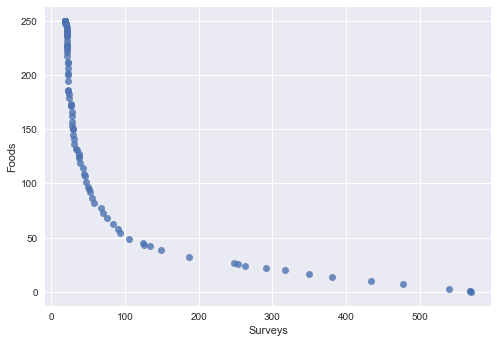

,Missing Survey Percentage,Surveys,Foods
39,0.39,22,212
42,0.42,23,202
49,0.49,26,173
52,0.52,28,166
59,0.59,31,141
61,0.61,34,132
63,0.63,37,127
66,0.66,39,119
67,0.67,43,114
68,0.68,44,109


In [15]:
l=[]
for missing_survey_perc in np.linspace(0.00, 1.00, num=101):
    df_before_preprocessing = df_answered_pivot.dropna(thresh=missing_survey_perc*len(df_answered_pivot), axis=1)
    l.append([missing_survey_perc, df_before_preprocessing.dropna().shape[0], df_before_preprocessing.dropna().shape[1]])

pareto = pd.DataFrame(l, columns=['Missing Survey Percentage', 'Surveys', 'Foods'])
sns.regplot(x=pareto['Surveys'], y=pareto['Foods'], fit_reg=False)
plt.show()

# plot summary of table:
pareto.loc[(pareto['Foods'].diff() < -3) & (pareto['Surveys'].diff() > 0)]

Note that rather than going through the complex multi-objective optimization, we opted to use a built-in parameter of panda's dropna() which allows you to drop rows or columns based on the percentage filled in that row or column. By checking in increments of 1%, our table should come fairly close to optimal for significantly less computational cost.

From there deciding is somewhat arbitrary, but given our already limited dataset, and that we want our sample size to be as large as possible for the sake of statistical power (especially considering our data scale), the three seemingly most useful options are dropping columns where there aren't 87% 88%, or 95% of rows filled (see table above for associated numbers of surveys and foods). We could work with one set at a time and swap out for a different choice later, but it's easy enough to create the dataframes for each option, saving them in a dictionary that we can iterate through for each analysis later:

In [16]:
df_dict = {}

thresh_dict = {'32':0.87, '27':0.88, '10':0.95}

for food_count, thresh in thresh_dict.items():
    df_dict['df_{0}foods'.format(food_count)]= df_answered_pivot.dropna(thresh=thresh*len(df_answered_pivot), axis=1).dropna(axis=0)

print('List of dataframes in our dictionary: ',[k for k in df_dict.keys()])
print('Let\'s make sure our 27 food dataframe\'s shape looks right: ', df_dict['df_32foods'].shape)
df_dict['df_32foods'].tail()

List of dataframes in our dictionary:  ['df_32foods', 'df_27foods', 'df_10foods']
Let's make sure our 27 food dataframe's shape looks right:  (187, 32)


name,Apple,Apple Juice,Bananas,Beef,Broccoli,Butter,Carrots,Cheese - Hard,Cheese - Soft,Chicken,...,Orange Juice (without bits),Peas,Pork,"Potatoes, White","Rice, White",Strawberries,Sugar,Tap Water,Tomatoes,Wheat
user_id,,,,,,,,,,,,,,,,,,,,,
3512,8.0,3.0,10.0,7.0,4.0,0.0,10.0,0.0,0.0,9.0,...,3.0,0.0,0.0,3.0,2.0,1.0,4.0,0.0,2.0,6.0
3513,8.0,2.0,10.0,6.0,2.0,2.0,8.0,6.0,2.0,9.0,...,9.0,0.0,9.0,3.0,1.0,7.0,0.0,10.0,8.0,1.0
3525,5.0,0.0,5.0,5.0,5.0,0.0,5.0,3.0,1.0,10.0,...,0.0,3.0,0.0,5.0,5.0,6.0,0.0,10.0,5.0,5.0
3539,10.0,6.0,10.0,0.0,10.0,0.0,7.0,0.0,0.0,0.0,...,10.0,9.0,0.0,0.0,0.0,9.0,0.0,10.0,10.0,0.0
3544,4.0,0.0,6.0,9.0,5.0,10.0,10.0,10.0,10.0,10.0,...,3.0,1.0,8.0,10.0,10.0,0.0,10.0,10.0,5.0,2.0


With that, we have a fully scrubbed data set to work with. Our one last step is to preprocess the data for our planned analysis.

# IBD Survey Data Preprocessing

While our data is already scaled to a common range, we will employ the [MinMaxScaler](http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler) (which in our case, given that every food has a 0 minimum and 10 maximum effectively just divides by 10 for our data), for a couple of reasons:
1. Some of our algorithms will run more quickly as a result of scaling and
2. Having all values between zero and one gives us a nice, easy option to convert the sometimes data (1-9) to either 0 or 1 via rounding, so we can look at foods on a simple can/can't eat basis.

In [17]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()

for k in [k for k in df_dict.keys()]:
    if 'scaled' not in k:
        df = df_dict.pop(k)
        v = min_max_scaler.fit_transform(df)
        df_dict[k+'_scaled'] = pd.DataFrame(v, columns=df.columns)
    else:
        print('This df is already scaled.')

df_dict['df_27foods_scaled'].tail()

# todo adjust index so the table below doesn't lose the user ID with this step

name,Apple,Bananas,Beef,Broccoli,Butter,Carrots,Cheese - Hard,Chicken,Chicken Egg,Chocolate - Milk,...,Orange,Orange Juice (without bits),Peas,"Potatoes, White","Rice, White",Strawberries,Sugar,Tap Water,Tomatoes,Wheat
243,0.8,1.0,0.7,0.4,0.0,1.0,0.0,0.9,0.8,0.2,...,0.5,0.3,0.0,0.3,0.2,0.1,0.4,0.0,0.2,0.6
244,0.8,1.0,0.6,0.2,0.2,0.8,0.6,0.9,0.9,0.1,...,0.9,0.9,0.0,0.3,0.1,0.7,0.0,1.0,0.8,0.1
245,0.5,0.5,0.5,0.5,0.0,0.5,0.3,1.0,0.5,0.2,...,0.5,0.0,0.3,0.5,0.5,0.6,0.0,1.0,0.5,0.5
246,1.0,1.0,0.0,1.0,0.0,0.7,0.0,0.0,0.3,0.6,...,1.0,1.0,0.9,0.0,0.0,0.9,0.0,1.0,1.0,0.0
247,0.4,0.6,0.9,0.5,1.0,1.0,1.0,1.0,1.0,0.9,...,1.0,0.3,0.1,1.0,1.0,0.0,1.0,1.0,0.5,0.2


Let's also create variations of each of our dataframes where the classification groupings are consolidated according to the following additional schemes:
* Where all values 0.0-0.9 are treated as 0 (can't eat), leaving scores of 1.0 as they are (can eat). This will let us conclude with greater confidence that a food CAN be eaten after our analysis.
* Where 0.0 is left as is (can't eat), changing all scores of 0.1-1.0 to 1.0 (can eat). This will let us conclude with greater confidence that a food CAN'T be eaten after our analysis.
* Where there are three distinct categories, leaving 0.0 and 1.0 as they are, but treating scores 0.1-0.9 as a third category. This will help us address both foods that can and can't be eaten, while also adding results about the intersections between can/can't eat for multiple foods. It will remove potential "noise" or "uncertainty" in survey resonses from our analysis.

We will do the same for df_answered_pivot, which is the table that still has missing values, because we will use that dataset for pairwise and association analyses (and any other analyses that can handle sparse data).

In [18]:
for k in [k for k in df_dict.keys()]:
    if '_0' not in k:
        df_dict[k+'_0-9v10'] = df_dict[k].applymap(np.floor)
        df_dict[k+'_0v1-10'] = df_dict[k].applymap(np.ceil)
        df_dict[k+'_0v1-9v10'] = df_dict[k].copy()
        df_dict[k+'_0v1-9v10'][(df_dict[k+'_0v1-9v10']>0.0) & (df_dict[k+'_0v1-9v10']<1.0)] = 0.5

df_dict_nodrop = {}
df_dict_nodrop['df_250foods_scaled_0-9v10_nodrop'] = df_answered_pivot.applymap(lambda x: x/10).applymap(np.floor)
df_dict_nodrop['df_250foods_scaled_0v1-9v10_nodrop'] = df_answered_pivot.applymap(lambda x: x/10)
df_dict_nodrop['df_250foods_scaled_0v1-9v10_nodrop'][(df_dict_nodrop['df_250foods_scaled_0v1-9v10_nodrop']>0.0) & (df_dict_nodrop['df_250foods_scaled_0v1-9v10_nodrop']<1.0)] = 0.5
df_dict_nodrop['df_250foods_scaled_0v1-10_nodrop'] = df_answered_pivot.applymap(lambda x: x/10).applymap(np.ceil)

display(df_dict['df_27foods_scaled_0v1-9v10'].tail())
display(df_dict_nodrop['df_250foods_scaled_0v1-9v10_nodrop'].tail())

name,Apple,Bananas,Beef,Broccoli,Butter,Carrots,Cheese - Hard,Chicken,Chicken Egg,Chocolate - Milk,...,Orange,Orange Juice (without bits),Peas,"Potatoes, White","Rice, White",Strawberries,Sugar,Tap Water,Tomatoes,Wheat
243,0.5,1.0,0.5,0.5,0.0,1.0,0.0,0.5,0.5,0.5,...,0.5,0.5,0.0,0.5,0.5,0.5,0.5,0.0,0.5,0.5
244,0.5,1.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.0,0.5,0.5,0.5,0.0,1.0,0.5,0.5
245,0.5,0.5,0.5,0.5,0.0,0.5,0.5,1.0,0.5,0.5,...,0.5,0.0,0.5,0.5,0.5,0.5,0.0,1.0,0.5,0.5
246,1.0,1.0,0.0,1.0,0.0,0.5,0.0,0.0,0.5,0.5,...,1.0,1.0,0.5,0.0,0.0,0.5,0.0,1.0,1.0,0.0
247,0.5,0.5,0.5,0.5,1.0,1.0,1.0,1.0,1.0,0.5,...,1.0,0.5,0.5,1.0,1.0,0.0,1.0,1.0,0.5,0.5


name,Agave Nectar,Almond,Almond Milk,Anchovy,Apple,Apple Juice,Apricot,Artichokes,Asparagus,Aspartame,...,Watercress,Watermelon,Wheat,Whiskey,Wine - Champagne,Wine - Pink,Wine - Red,Wine - Sparkling,Wine - White,Yoghurt - Plain
user_id,,,,,,,,,,,,,,,,,,,,,
3544,NaN,1.0,NaN,1.0,0.5,0.0,0.5,1.0,1.0,NaN,...,1.0,1.0,0.5,0.5,0.5,0.5,0.5,0.5,0.0,1.0
3558,0.5,0.5,1.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
3559,NaN,1.0,NaN,NaN,1.0,0.0,NaN,0.5,0.5,0.5,...,NaN,0.5,NaN,NaN,0.5,0.5,NaN,0.5,0.5,0.5
3563,NaN,0.5,0.5,NaN,0.5,NaN,NaN,NaN,0.5,NaN,...,NaN,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.5
3566,NaN,NaN,NaN,NaN,0.5,NaN,0.5,NaN,NaN,NaN,...,NaN,1.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.5


# IBD Survey Analysis with Machine Learning

With the multiple datasets we've created, we will try to answer our initial questions (reprinted from above):
1. Are there any identifiable sub-clusters of diet among the survey participants?
2. Are there relationships between individual foods or groups of foods? If so, can we 
  1. find common nutrient links between those foods? or 
  2. use that information to reduce the dimensionality of our features and improve our ability to predict food tolerance/intolerance?
3. Are there any nutrients, vitamins, or minerals that impact food tolerance?
4. Can food tolerance/intolerance be predicted with a reasonable degree of accuracy (ideally probability) for an IDB sufferer with only a few “known” safe/unsafe foods?

If there are any clusters, it'd be beneficial to identify those first, so as to improve the accuracy of later tests. And both annecodatally and logically we'd expect to find at least two overall diet clusters - for our two primary types of IBD (Ulcerative Colitis and Crohn's Disease). After that, we can look for other relationships in the data using unsupervised and supervised methods, followed by [hopefully] a recommendation system. The initial plan is as follows:
1. Use unsupervised techniques to identify clusters.
  1. Use cosine similarity to correct for our "distance" problem given the unequal distances from 0.0 to 0.1 and 0.9 to 1.0 versus the rest of the intervals.
  2. Run pairwise and overall dbscans to identify any clusters. 
  3. Use a combination of homogeneity, completeness (and combined into V-measure), and silhouette coefficient to evaluate potentially interesting results.
2. Identify relationships between foods using chi-squre + Cramer's V (phi) and ordinal logistic regression.
3. For every vitamin, look up the food's value. Rank the vitamin value by food (% of range max-min). By vitamin, compare all survey questions. X=% vitamin for food, y=0 or 1 for yes/no could/count't eat. Run logistic regression and chi-square for each vitamin. This can be run with the original column-style data.
4. Predict food tolerances using supervised machine learning techniques including apriori algorithm/FP-growth, ordinal regression, and random forest.

# 1. Clustering (DBSCAN)

Since we are attempting to cluster our data without knowing the categories or even number of categories in advance, and are instead using clustering as a means of exploratory data analysis, our choice of clustering algorithm is especially important. While k-means is an incredibly popular algorithm given how fast and intuitive it is, it suffers from three problems that would hinder our initial analysis:
1. We need to know the number of clusters in advance (the k in k-means) or test multiple ks and attempt to identify the "best" one (commonly found with the 'elbow' point while comparing multiple ks and the average of their associated within-cluster distances; see this [link](https://www.datascience.com/blog/k-means-clustering) for an explanation of the method).
2. It makes assumptions/has limitations with regards to the shape of the clusters (convex/globular).
3. Generally it requires the number of data samples to be much greater than the number of features (which would work for our pairwise analysis, but not overall).

While each unsupervised clustering method has its limitations (see this [link](https://www.datascience.com/blog/k-means-clustering) for a review of each one's strengths and weaknesses), DBSCAN seems to be a good combination of not making assumptions, being able to handle weirdly shaped clusters, addressing our distance issues, and, most importantly, not requiring us to know the number of clusters. While logically we'd expect at least two (for Crohn's Disease and Ulcerative Colitis), part of this clustering exercise is to determine how many (if any) clusters there are, before we decide how to subgroup our data. 

[DBSCAN](https://en.wikipedia.org/wiki/DBSCAN) (Density-Based Spatial Clustering of Applications with Noise) is an algorithm that views clusters as areas of high density (where a set of samples are close to each other using some measure of distance) separated by areas of low density, and can identify clusters of any shape.

First, we start with pairwise clustering for each of our 250 foods. We fill only visualize pairs where there are at least two clusters and where the threshold for our chosen method of validation (Silhouette Coefficient) is met. We will also write code to provide additional validation statistics in the event that we are ever able to test labels for our data (e.g. if we can later gain access to the type of IBD of each survey participant).

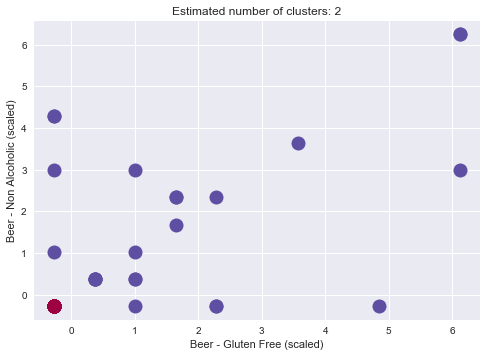

Silhouette Coefficient: 0.859 



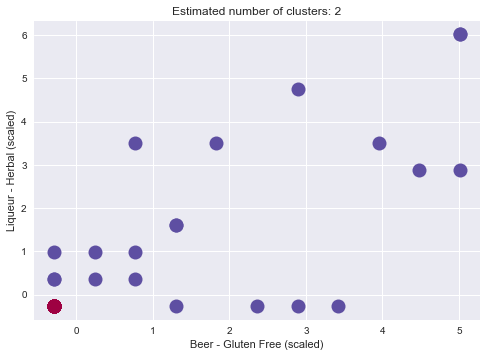

Silhouette Coefficient: 0.861 



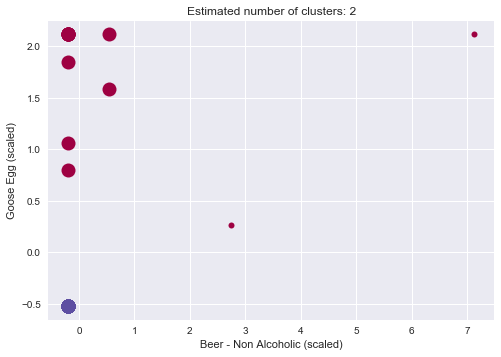

Silhouette Coefficient: 0.852 



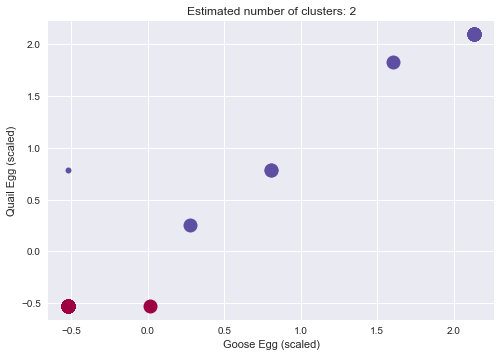

Silhouette Coefficient: 0.893 

Wall time: 4min 18s


In [19]:
%%time

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler


def plot_cluster(X, food1, food2, core_samples_mask, labels, n_clusters_):
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)
    
    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.xlabel(food1 + ' (scaled)')
    plt.ylabel(food2 + ' (scaled)')
    plt.show()


def run_dbscan(df, food1=None, food2=None, true_labels=None):
    X = StandardScaler().fit_transform(df)
    db = DBSCAN(eps=0.8, algorithm='brute', metric='cosine', min_samples=10).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True

    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    
    if n_clusters_ > 1:
        sil = metrics.silhouette_score(X, labels)
        if food1 and food2:
            if sil > 0.85:
                plot_cluster(X, food1, food2, core_samples_mask, labels, n_clusters_)
                print("Silhouette Coefficient: %0.3f \n" % metrics.silhouette_score(X, labels))
    
    if true_labels:
        if metrics.v_measure_score(labels_true, labels) > 0.5:
            print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
            print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
            print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
            print("Adjusted Rand Index: %0.3f"
                  % metrics.adjusted_rand_score(labels_true, labels))
            print("Adjusted Mutual Information: %0.3f"
                  % metrics.adjusted_mutual_info_score(labels_true, labels))
        
for i in range(df_answered_pivot.shape[1]):
    for j in range(i+1, df_answered_pivot.shape[1]):
        df = pd.concat([df_answered_pivot.iloc[:,i], df_answered_pivot.iloc[:,j]], axis=1).dropna()
        run_dbscan(df, df_answered_pivot.columns[i], df_answered_pivot.columns[j])

While a number of pairs with at least two clusters were identified, and many had strong Silhouette Coefficients, many of those clusters were for food pairs that rarely appear in our dataset. Additionally, upon visual inspection, many of the clusters only pull out one cluster of people who can't eat both foods - potentially informative, but not as useful in setting up our later analysis. To that same end, the foods with clusters are not features in our more concentrated datasets that we'll be able to use for our later questions. 

Viewing the broader set of scatterplots (not displayed above for sake of space) of pairwise relationships, it becomes clear that answers are simply too heterogeneous to reasonably determine any kind of unique clusters in most cases. While our data can't say definitively that there are no clusters in many of the pairs, it seems improbable and certainly won't be identifiable with our limited number of records currently in our dataset. 

Let's see if our overall dataset sheds more light:

In [20]:
%%time

# DBSCAN requires nan-less data
run_dbscan(df_dict['df_32foods_scaled'])

Wall time: 5.01 ms


Our run_dbscan() only displays an output if more than one cluster is found, which means unfortunately our clustering for the 32food data set didn't find anything useful.

# 2. Food Comparisons (Chi-Square)

In [21]:
# %%time
# from scipy.stats import chi2_contingency

# for k in [k for k in df_dict_nodrop.keys()]:
#     df = df_dict_nodrop[k]
#     for i in range(df.shape[1]):
#         for j in range(i+1, df.shape[1]):
#             pair_df = pd.concat([df.iloc[:,[i]], df.iloc[:,[j]]], axis=1).dropna()
#             columns = list(pair_df)
#             groupsizes = pair_df.groupby([columns[0], columns[1]]).size()
#             ctsum = groupsizes.unstack(columns[0])
#             if chi2_contingency(ctsum.fillna(0))[1] < 0.05:
#                 print(ctsum)
#                 print(chi2_contingency(ctsum.fillna(0)))

In [22]:
# for k in [k for k in df_dict.keys()]:
#     df = df_dict[k]
#     for i in range(df.shape[1]):
#         for j in range(i+1, df.shape[1]:
#             print(df.iloc[:,i], df.iloc[:,j])
#             # cosine of pair
#             # run pairwise tests for foods (columns) i and j
#             # capture i, j, performance evaluation in db table

# 3. Nutrient, Vitamin, & Mineral Impact (Ordinal Regression)

Given time constraints for this project, difficulty matching food names from the dataset with those used by the USDA database, and the strong results acheived with association learning (below), this analysis will be completed at a later date.

However, before the difficulties were realized, we created a tool to query the USDA's API's four end-points that can be found as a standalone project at [https://github.com/ZaxR/usda_db_tool](https://github.com/ZaxR/usda_db_tool) or tweaked for this project in this project's github repository at [https://github.com/ZaxR/ibd_diet_analysis](https://github.com/ZaxR/ibd_diet_analysis)

# 4. Food Tolerance Predictions with Association Learning (FP-Growth)

We next attempt to draw associations within our data using association rule learning. [Association rule learning](https://en.wikipedia.org/wiki/Association_rule_learning) attempts to mine binary data to draw associations between items in the dataset based on frequency in the form of a (or multiple) measure(s) of "interestingness." The most famous examples of an association learning problem is a "market basket" transaction problem, where a retailer attempts to find items that are frequenty purchased together, using the resulting "rules" to help target specific types of customers (and drive additional sales).

The broader process for association analysis involves two steps: 1) discoverying/generating frequent itemsets/patterns in your data and 2) rule generation.

What can make association mining challenging is the relative inefficiency of frequent itemset generation, and therefore the computational complexity. A naive, brute-force attempt to find all possible item sets (the "power set") and then exclude infrequent ones is exponential time complexity! Attempting to analyze for just 27 potential "items" potentially requires 134,217,727 calculations (2^27-1). However, the "Apriori Principle" and other efficiency tricks can reduce the calculation dramatically (this [chapter of Introduction to Data Mining](https://www-users.cs.umn.edu/~kumar/dmbook/ch6.pdf) by Tan, Steinbach, and Kumar is a fascinating/informative introduction to the topic).

Initially, we attemped to use an efficient implementation of the apriori algorithm (code excluded from this notebook for brevity), but found that it still wasn't efficient enough to use for our analysis. As a result, we will switch to a more efficient, but more complex algorithm known as FP-growth (using Christian Borgelt's [PyFIM](http://www.borgelt.net/pyfim.html) -- the only accuracte, efficient, and feature-rich module found for python), which is two orders of manitude more efficient for frequent item set genreation than apriori.

First, we will use our 32-food 0-9v10 dataset. Technically we could actually use our entire dataset, since missing items will be ignored, but even utilizing FP-growth, large datasets can take a long time to run, so we will save such analysis for later.

What we hope our association analysis will be able to do is find common subsets of foods and their associated rules that occur frequently (known as "support"), with confidence (known as "confidence"), and more often than would be expected by random chance (known as "lift") (check out [this resource](http://michael.hahsler.net/research/association_rules/measures.html) for information on other measures of interestingness). We could then use those rules to make intuitive, straightforward recommendations to survey-takers!

However, because we hope to answer not only what foods people can eat, but also those that they can't, we will take a somewhat novel approach to the the data, inputting logically ternary data as opposed to truly binary data typically used with the traditional association rules. For every possible food in our dataset, we will also create a "Not Food" variance, denoting a food the person can't eat (and as a result, potential recommendations of not eating foods). Such analysis will create a "new" problem for us, which is that rules could potentially conflict (e.g we could have two rules saying 1) Chicken + Milk --> Beef and 2) Chicken + Milk + Not Avocado --> Not Beef). We will address our attempt to handle that difficult in-depth below.

We will also add a third step to the general association rule learning process -- a [potentially novel?] method of cross-validation. While association learning is inherently self-validating (more detail below) we will use the validation as second-order validation, looking at the interestingness of our interestingness (in other words, making sure our interestingness criteria actually help us generate useful rules).

In [23]:
%%time

import json
import sys
from fim import fpgrowth
from sklearn.cross_validation import train_test_split


def df_to_association_input(df):
    #Convert df to acceptable input format for apyori.apriori()
    transactions = df.copy()
    for col in transactions.columns:
        transactions[col].replace([1, 0.5, 0], [col, '', 'not '+col], inplace=True)

    transactions = transactions.values.tolist()

    for i, entry in enumerate(transactions):
        transactions[i][:] = filter(bool, entry)
    
    return transactions  # transactions_train, transactions_test


def generate_association_rules(df_input, supp = 20, conf = 80, train_test=False):
    def run_fpgrowth(data):
        rules_df = pd.DataFrame(fpgrowth(data, target='r', supp=supp, conf=conf, report='bCl',
                                 eval='l', agg='n', thresh=1, appear={'Filtered Water': '-', 'Tap Water': '-'}),
                        columns=['Consequent', 'Antecedents', 'Support (Count)', 'Confidence (%)','Lift (x)'],
                        index=None, copy=False)

        print('Length of data set: ', len(data))
        print('Number of rules: ', len(rules_df))
        print('Bytes of memory used: ', sys.getsizeof(rules_df), '\n')
        
        return rules_df
        
    df_input_copy = df_input.copy()
    association_input = df_to_association_input(df_input_copy)
    
    if train_test:
        association_train, association_test = train_test_split(association_input, test_size=0.2)
        return run_fpgrowth(association_train), association_test
    else:
        return run_fpgrowth(association_input)


# df_dict['df_32foods_scaled_0v1-9v10'].copy() works better
original_dataset_df = (df_dict_nodrop['df_250foods_scaled_0v1-9v10_nodrop']
                       .copy()
                       .dropna(thresh=0.75*len(df_dict_nodrop['df_250foods_scaled_0v1-9v10_nodrop']), axis=1))
training_rules_df, association_test = generate_association_rules(original_dataset_df, supp=15, conf=90, train_test=True)
training_rules_df.to_csv('training_association_rules.csv')

C:\Anaconda\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Length of data set:  456
Number of rules:  2255
Bytes of memory used:  330015 

Wall time: 1.66 s


We notice that the number of rules genreated by multiple splits of train and test sets ranges quite widely: from 819-4827 in our 20 attempts. This could be caused by a lack of data, poor parameter level choices, simply be a product of the data itself, or some combination of the three. In tweaking the parameters we were unable to narrow the relative range of rules to a statistically significant degree (for reasonable parameter thresholds), which suggests to us that the variation might be a result of limited/weak data. We will investigate further when we cross validate our rules, looking for material differences in 1) accuracy and 2) generated rules. For now, we will continue:

In [24]:
training_rules_df.head()

,Consequent,Antecedents,Support (Count),Confidence (%),Lift (x)
0,Chicken,"(Cod, Potatoes, White)",149,91.275168,1.406131
1,Chicken,"(Cod, Chicken Egg)",156,90.384615,1.392412
2,Chicken,"(Cod, Chicken Egg, Potatoes, White)",118,91.525424,1.409986
3,Chicken,"(Cod, Carrots, Potatoes, White)",110,91.818182,1.414496
4,Chicken,"(Cod, Carrots, Chicken Egg)",105,92.380952,1.423166


Let's take a look at what kinds of rules we produced:

In [25]:
def summary_table(df):
    df = df.groupby(['Consequent']).agg({'Antecedents': lambda ante: list(ante),
                                         'Support (Count)': [np.min, 'mean', np.max], 
                                         'Confidence (%)': [np.min, np.mean, np.max], 
                                         'Lift (x)': [np.min, np.mean, np.max]
                                        }).reset_index()

    
    format_mapping={'Support (Count)': '{:.0f}', 'Confidence (%)': '{:.2f}%', 'Lift (x)': '{:.2f}x'} 
    for k, v in format_mapping.items():
        df[k] = df[k].applymap(v.format)
    
    # todo fix the background_gradient; currently not working; dtypes are all objects after formatting
    cm = sns.light_palette("green", as_cmap=True)
    df.style.background_gradient(cmap=cm)
        
    return df

training_grouped_rules_df = summary_table(training_rules_df)
training_grouped_rules_df

Consequent  \
                                   
0                    Blueberries   
1                         Butter   
2                        Carrots   
3                  Cheese - Hard   
4                        Chicken   
5                    Chicken Egg   
6               Chocolate - Milk   
7                            Cod   
8                       Cucumber   
9                          Lemon   
10                       Lettuce   
11                          Lime   
12             Melon, Cantaloupe   
13               Melon, Honeydew   
14                        Orange   
15                         Peach   
16               Potatoes, White   
17                   Raspberries   
18                   Rice, White   
19                        Salmon   
20                  Strawberries   
21                     Tangerine   
22                          Tuna   
23                        Turkey   
24                    Watermelon   
25                    not Almond   
26              not Blackberries   
27                   not Cashews   
28                      not Lime   
29                 not Nectarine   
30                    not Orange   
31  not Orange Juice (with bits)   
32                   not Peanuts   
33                     not Plums   
34                   not Raisins   
35               not Raspberries   
36                 not Tangerine   

                                          Antecedents Support (Count)       \
                                             <lambda>            amin mean   
0   [(Blackberries, Raspberries, Strawberries), (B...              70   70   
1                                          [(Cream,)]              71   71   
2   [(Salmon, Bananas, Rice, White, Potatoes, Whit...              69   73   
3   [(Cheese - Soft, Rice, White, Potatoes, White)...              69   72   
4   [(Cod, Potatoes, White), (Cod, Chicken Egg), (...              69   80   
5   [(Cauliflower, Cod, Chicken), (Pork, Tuna, Chi...              70   72   
6   [(Chocolate - White, Chicken), (Chocolate - Wh...              69   75   
7   [(Salmon, Tuna, Rice, White, Potatoes, White),...              69   75   
8                      [(Mango, Watermelon, Carrots)]              72   72   
9   [(Lime, Chicken), (Lime, Potatoes, White, Chic...              69   75   
10                [(Mushroom, Strawberries, Carrots)]              70   70   
11  [(Lemon, Potatoes, White, Chicken), (Lemon, Ri...              69   75   
12  [(Melon, Honeydew, Cod, Potatoes, White, Chick...              69   75   
13  [(Watermelon, Cod, Chicken Egg), (Watermelon, ...              69   76   
14  [(Tangerine, Bananas), (Tangerine, Sweet Potat...              71   72   
15                                [(Pear, Nectarine)]              70   70   
16  [(Rice, White, Cod, Carrots, Chicken Egg), (Tu...              69   74   
17  [(Blackberries, Chicken), (Blackberries, Chick...              70   72   
18  [(Sweet Potato, Salmon, Potatoes, White, Chick...              69   73   
19  [(Bananas, Tuna, Rice, White, Cod), (Sweet Pot...              69   74   
20  [(Blueberries, Melon, Honeydew, Carrots), (Blu...              69   72   
21                                [(Orange, Lettuce)]              72   72   
22  [(Salmon, Cod, Chicken Egg, Chicken), (Salmon,...              69   74   
23  [(Sweet Potato, Tuna, Rice, White, Potatoes, W...              69   74   
24  [(Blueberries, Melon, Honeydew, Cucumber), (Ra...              70   72   
25  [(not Cashews, not Orange Juice (with bits)), ...              70   72   
26                               [(not Blueberries,)]              76   76   
27  [(not Almond, not Peanuts, not Orange Juice (w...              69   79   
28                                     [(not Lemon,)]              77   77   
29  [(not Orange, not Tangerine, not Raisins), (no...              69   73   
30  [(not Nectarine, not Orange Juice (with bits))...              69   71   
31  [(not Orange Juice (without bits), not 

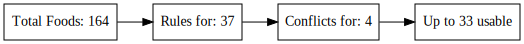

In [26]:
def check_conflicting_rules(rule_consequent_set):
    # todo use set intercection instead
    not_foods = set()
    reg_foods = set()
    for food in rule_consequent_set:
        if food.startswith('not '):
            not_foods.add(food)
        else:
            reg_foods.add(food)

    return [x for x in reg_foods if 'not '+x in not_foods] + [y for y in not_foods if y[4:] in reg_foods]

def visualize_available_food_rules(total_foods, grouped_df):
    total_foods = total_foods.columns.tolist() + ['not '+x for x in total_foods.columns.tolist()]
    rules_for = grouped_df['Consequent'].tolist()
    conflicts = check_conflicting_rules(rules_for)
    overall_possible_rules = int(len(rules_for) - len(conflicts)/2)

    d1 = gv.Digraph(node_attr={'shape':'box'}, graph_attr={'rankdir': 'LR'})

    d1.node(str(total_foods), 'Total Foods: {}'.format(len(total_foods)))
    d1.node(str(rules_for), 'Rules for: {}'.format(len(rules_for)))
    d1.node(str(conflicts), 'Conflicts for: {}'.format(int(len(conflicts)/2)))
    d1.node(str(overall_possible_rules), 'Up to {} usable'.format(overall_possible_rules))
    d1.edge(str(total_foods), str(rules_for))
    d1.edge(str(rules_for), str(conflicts))
    d1.edge(str(conflicts), str(overall_possible_rules))
    
    return d1, total_foods, rules_for, conflicts, overall_possible_rules

# rules for, conflicts for, and usable all reflect the training set
d1, total_foods, rules_for, conflicts, overall_possible_rules = visualize_available_food_rules(original_dataset_df, training_grouped_rules_df)
d1

## Handling Conflicting Rules

NOTE: This section is still under review.

Our rules generate a number of conflicting rules, where both a food and "not" that same food are recommended. The question is, what do we do with the conflicts? Should we keep one, both, or neither of them in our overall data set? Should we keep any for specific users?

To help us decide, let's walk through an example. Let's imagine a user who only knows they can eat 1) Chicken and 2) not Grapes. There might also be two rules generated by our model that say 1) Chicken + not Grapes + Banana --> Orange and 2) Chicken + not Grapes --> not Orange. The rules give opposite recommendations, but rule #1 doesn't apply to our user in this hypothetical case, while rule #2 does. Since there's only one rule that applies, the recommendation might seem clear if we only filter out conflicts on a user level. However, we don't know the user's answer to Bananas, and that would make a material difference to the outcome. More importantly, there IS a correct answer for the user, and we don't want to steer someone in the wrong direction.

That said, if we take the approach of simply excluding all rules that conflict from the overall rule set, we will reduce the number of recommendations we can make, when there might be valuable information.

The question as to whether to exclude rules on the basis of the overall data set or on the user level then, depends on which type of error we're most confortable in making. Would we rather:
1. filter on the user-specific level, and accidentally recommend a wrong food or not food rule (type I error) -or-
2. filter on the overall data set level, and accidentally NOT make a recommendation when there could be one (type II error)

Regardless of our choice, there is going to be some chance of error, so our goals should be to maximize the recommendations we can make, while understanding the risk we're accepting, and minimizing that risk where possible. Predicting the relative amounts of type I and type II error will be nearly impossible, given our ever changing data set and new user inputs, so instead we will focus on maximizing recommendations while understanding our risk and trying to resolve conflicts. To that end, we will look for conflicts in both the overall rule set as well as on a user basis, but defer removal of recommendations until we're sure we have to. Before we remove conflicts, thought, we will attempt to reconcile the issue. Let's return to our hypothetical scenario.

If we have rules for both Chicken + not Grapes --> not Orange and Chicken + not Grapes + Banana --> Orange, we can logically conclude that Banana is the more meaningful swing factor in determining if we can eat oranges. In this simple scenario instead of simply having returned either nothing to the user (because the conflict was removed at the overall rule set level) or to not eat oranges (because that was the only rule that directly applied to the user) we could "resolve" the conflict by first identifying the key determining antecedants and giving a recommendation based on a rule for that food (banana) instead, or if that's not an option, as in this case, we can take one step earlier in the chain, looking for predictors of that food (banana) - being careful not to take too many "steps" and dwindle our confidence. An example of our output if this step works would be something like "Based on only the foods you're known to be able to eat, we'd recommend you not eat oranges with 92% confidence. However, bananas are a better predictor of whether or not you can eat oranges. Your ability to eat X and Y predicts you can eat bananas with z% probability. Therefore, we recommend that you can eat oranges with z% probability." If we can't make a statement like the last one, we would simply change the last two sentences to "We cannot predict your ability to eat oranges at this time." Not super useful in our example case, but information none-the-less. 

Advancing our overly simplistic example again, it seems more likely our rules wouldn't be as simple as A + notB --> notM vs A + notB + C --> M. Instead, our second case might be  A + notB + C + D + E --> M, meaning C + D + E combined are the determining facor. We can then find rules with subsets of C + D + E --> M, continuing to look for the most important factors. Because of the apriori rule (that all subsets of frequent subset are frequent themselves), we know that the smaller subsets of the antecedant will all be frequent to help us in our reduction, only limited by the smaller subset being predictive for the consequent. So when we are no longer able to reduce, we will know that the remaining antecedant are all the determining factors in combination.

As a result, whenever there's a conflict in our larger data set, we can find the longest antecedents with each of M and notM as the consequent, and reduce our way down to an answer of the relvant foods in making a prediction on M, for the user.

In other words, from an implementation point of view, we will first identify all conflicts for our overall dataset, but keep them "in" as possibilities. We will then use logic and linear combination with all rules that lead to the conflicting consequents to try and identify the most important features (foods or not foods). This information will be stored for later use. Then, on a user level, pull out all conflict-related rules (ones where there were conflicting consequents in overall rules) from the list of rules that apply to the specific user. Identify if there exists a conflict in the user's output. If so, attempt to resolve using the most important features. If that's not possible, of if there's no conflict in the user's output, categorize it as a usesr-level conflict, unresolvable and present any/all available information (for example, "Food W is the best predictor of whether or not you can really eat M. We predict you can eat W with X probability.)

In an alternative example, we might have 12 rules between orange and not orange, with 11 recommending not eating oranges and only 1 recommending eating them. As an alternative method of conflic resoltion in such a case we could, in effect use a second order support measure (on a user basis) to choose between conflicting rules.

Other musings:
* As our data set becomes large, will we have more or less conflcits? Our theory is that rules will become more representative of the population with more data, as larger and larger counts are required for our support threshold, however there may be more, less, or the same number of conflicts. The conflicts that do exist, though, would become more reflective of true conflicts - either informing us of foods that swing the equation or letting us know there are subsets of people missed in clustering. ((remember foods or not foods with low "support" are excluded based on a % threshold)).

Note: after implementing our methodology, and potentially reconciling conflicts, there will be a new 5th layer in our test trees where conflict can make to being correct/incorrect/new -or- unreconciled.

In [27]:
# todo attempt to resolve conflicts with linear combination
# then update trees to add a layer for resolved and unresolved conflicts. Resolved conflicts should feed into usable

In [28]:
# could this instead just be done on group_rules_df?
def remove_conflicts(df, conflicts):
    rules_df_noconflict = df[~df['Consequent'].isin(conflicts)]
    if len(df) != len(rules_df_noconflict):
        print('Rules reduced from {} to {}.'.format(len(df), len(rules_df_noconflict)))
    return rules_df_noconflict
    
training_rules_df_noconflict = remove_conflicts(training_rules_df, conflicts)

Rules reduced from 2255 to 2159.


Now that we've removed out conflicts, let's check out our summary table again:

In [29]:
# for the training set
summary_table(training_rules_df_noconflict)

Consequent  \
                                   
0                    Blueberries   
1                         Butter   
2                        Carrots   
3                  Cheese - Hard   
4                        Chicken   
5                    Chicken Egg   
6               Chocolate - Milk   
7                            Cod   
8                       Cucumber   
9                          Lemon   
10                       Lettuce   
11             Melon, Cantaloupe   
12               Melon, Honeydew   
13                         Peach   
14               Potatoes, White   
15                   Rice, White   
16                        Salmon   
17                  Strawberries   
18                          Tuna   
19                        Turkey   
20                    Watermelon   
21                    not Almond   
22              not Blackberries   
23                   not Cashews   
24                 not Nectarine   
25  not Orange Juice (with bits)   
26                   not Peanuts   
27                     not Plums   
28                   not Raisins   

                                          Antecedents Support (Count)       \
                                             <lambda>            amin mean   
0   [(Blackberries, Raspberries, Strawberries), (B...              70   70   
1                                          [(Cream,)]              71   71   
2   [(Salmon, Bananas, Rice, White, Potatoes, Whit...              69   73   
3   [(Cheese - Soft, Rice, White, Potatoes, White)...              69   72   
4   [(Cod, Potatoes, White), (Cod, Chicken Egg), (...              69   80   
5   [(Cauliflower, Cod, Chicken), (Pork, Tuna, Chi...              70   72   
6   [(Chocolate - White, Chicken), (Chocolate - Wh...              69   75   
7   [(Salmon, Tuna, Rice, White, Potatoes, White),...              69   75   
8                      [(Mango, Watermelon, Carrots)]              72   72   
9   [(Lime, Chicken), (Lime, Potatoes, White, Chic...              69   75   
10                [(Mushroom, Strawberries, Carrots)]              70   70   
11  [(Melon, Honeydew, Cod, Potatoes, White, Chick...              69   75   
12  [(Watermelon, Cod, Chicken Egg), (Watermelon, ...              69   76   
13                                [(Pear, Nectarine)]              70   70   
14  [(Rice, White, Cod, Carrots, Chicken Egg), (Tu...              69   74   
15  [(Sweet Potato, Salmon, Potatoes, White, Chick...              69   73   
16  [(Bananas, Tuna, Rice, White, Cod), (Sweet Pot...              69   74   
17  [(Blueberries, Melon, Honeydew, Carrots), (Blu...              69   72   
18  [(Salmon, Cod, Chicken Egg, Chicken), (Salmon,...              69   74   
19  [(Sweet Potato, Tuna, Rice, White, Potatoes, W...              69   74   
20  [(Blueberries, Melon, Honeydew, Cucumber), (Ra...              70   72   
21  [(not Cashews, not Orange Juice (with bits)), ...              70   72   
22                               [(not Blueberries,)]              76   76   
23  [(not Almond, not Peanuts, not Orange Juice (w...              69   79   
24  [(not Orange, not Tangerine, not Raisins), (no...              69   73   
25  [(not Orange Juice (without bits), not Orange)...              69   74   
26  [(not Almond, not Raisins), (not Almond, not T...              72   79   
27  [(not Kiwi, not Orange, not Tangerine), (not N...              69   71   
28  [(not Nectarine, not Kiwi, not Tangerine), (no...              69   71   

        Confidence (%)                  Lift (x)                
   amax           amin    mean     amax     amin   mean   amax  
0    70         90.00%  90.71%   91.43%    3.42x  3.45x  3.47x  
1    71         91.55%  91.55%   91.55%    2.50x  2.50x  2.50x  
2    92         90.00%  91.36%   97.10%    1.88x  1.91x  2.03x  
3    87         90.00%  94.04%   98.57%    3.34x  3.49x  3.65x  
4   214         90.00%  94.58%  100.00%    1.39x  1.46x  1.54x  
5    73         90.28%  91.29% 

## Cross-Validation

Now we want to see how accurate our results are, so that we might compare to other methods of recommendation. In this regard, association rules are largely self-validating. That is to say, our measures of interestingness, particularly confidence, already reflect how "accurate" our rules are for all included data.

That said, we take the approaches of cross-validating below, in which 1) the data is divided into training and test sets, 2) each transaction in the test set has rules (from the training set) that are subsets of the transaction tested for accuracy, 3) 'correct', 'incorrect', 'new recommendations', and 'missed opportunities' are tracked, and 4) the quality of the results are assessed to improve the model. Our second approach involves repeating steps 1-4, comparing the results and rules of multiple attempts at this process.

In effect, this method of cross validation should provide validation in our measures of interestingness or second order validation (i.e. validation of validation). The purpose of such analysis is to ensure that our selection for measures of interestingness and the levels at which we'll filter them are indeed generating useful rules (and adjust rules and/or parameters accordingly). In academic research there appear to be just a handful of papers addressing the topic of cross-validating association learnings (see [this paper](https://bvicam.ac.in/news/INDIACom%202008%20Proceedings/pdfs/papers/229.pdf) for an approach somewhat similar to the second approach we take, and [this paper](http://home.ijasca.com/data/documents/IJASCA_nvApriori.pdf) for a more rigorous approach for which our data set is too small), which leaves us largely "on our own" for testing the new validation method. 

Here are some other relevant papers to the topic of assessing/tweaking interestingness:
* [Finding Association Rules that Trade Support Optimally Against Confidence](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.70.9777&rep=rep1&type=pdf)

In [30]:
%%time
# todo clean up this cell's code

def generate_applicable_rules(transaction_input, total_df):
    # checks every transaction input for rules where the antecedents are a subset of the transaction
    # allows us to check the recommendations from those rules to see if they're accurate
    for rule in [r for idx, r in total_df.iterrows()]:
        if set(rule['Antecedents']).issubset(transaction_input):
            yield rule
    

def crosstrain_association(test_data):
    transaction_no = 0
    test_analytics = {}
    graph_list = []
    
    for transaction in test_data:
        transaction_no += 1
        correct_list, incorrect_list, new_list, missed_list = [], [], [], []
        rule_list = []
        rec_list = []
        conflict_list = []
        new_rec = 0
        correct = 0  
        incorrect = 0

        for rule in generate_applicable_rules(transaction, training_rules_df): # all recommended foods based on being a subset of transaction
            rule_list.append(rule)
            rec_list.append(rule['Consequent'])
        
        conflicts_for = check_conflicting_rules(set(rec_list))

        
        if len(rule_list) > 0:
            '''
            Both correct and incorrect implicity assume all rules for a specific food make the same recommendation. To ensure
            accuracy this requires conflicts to be removed from training set first.
            '''
            no_conflict_rules = remove_conflicts(pd.DataFrame(rule_list), conflicts_for)
            #no_conflict_for = [x for x in rec_list if x not in conflicts_for]
            no_conflict_for = no_conflict_rules['Consequent'].tolist()
        else:
            no_conflict_for = rule_list
        
        for c in set(no_conflict_for):
            if c in transaction:
                correct += 1
                correct_list.append(c)
            else:
                if c.startswith('not '):
                    if c[4:] in transaction:
                        incorrect += 1
                        incorrect_list.append(c)
                    else:
                        new_rec += 1
                        new_list.append(c)
                else:
                    if 'not '+c in transaction:
                        incorrect += 1
                        incorrect_list.append(c)
                    else:
                        new_rec += 1
                        new_list.append(c)

        # Adds to sum of correct, incorrect, and new recommendations to total possible recommendations 
        user_possible = int(len(set(rec_list)) - len(conflicts_for)/2)
        missed_opp = overall_possible_rules - user_possible
        
        # unit testing only
        if missed_opp < 0:
            print(transaction_no, ' has missing opps less than 0')
        
        # todo apply formatting to table later, so accuracy column are values usable for calculation
        accuracy = '{:.2f}%'.format(correct / (correct + incorrect) * 100) if (correct + incorrect != 0) else 'N/A'
        
        test_analytics[transaction_no] = {'Accuracy': accuracy, 'Correct': correct_list, 'Incorrect': incorrect_list, 
                                          'New':new_list}  # 'Missed': xxx
        
        # Create tree visualization
        filename = 'test_renders/'+str(transaction_no)+'.gv'
        d = gv.Digraph(filename=filename, format='png',
                       node_attr={'shape':'box', 'pos':'r'},
                       graph_attr={'rankdir': 'LR'}, 
                       edge_attr={'headport':'w', 'tailport':'e'})

        d.node('A', 'Overall\nPossible\nRecommendations:{}'.format(overall_possible_rules))
        d.node('B', 'User\nPossible\nRecommendations:{}'.format(int(len(set(rec_list)) - len(conflicts_for)/2)))
        d.node('C', 'Missed\nRecommendations: {}'.format(missed_opp))
        d.node('D', 'Usable\nRecommendations:{}'.format(len(set(no_conflict_for))))
        d.node('E', 'Conflicting\nRecommendations:{}'.format(int(len(conflicts_for)/2)))
        d.node('J', 'Missed\nRecommendations: {}'.format(missed_opp))
        d.node('M', 'Unreconciled\nConflicts:{}'.format(int(len(conflicts_for)/2)))
        d.node('F', 'Correct: {}'.format(correct))
        d.node('G', 'Incorrect: {}'.format(incorrect))
        d.node('H', 'New: {}'.format(new_rec))
        d.node('K', 'Missed\nRecommendations: {}'.format(missed_opp))
        d.node('I', 'Accuracy: {}'.format(accuracy))

        d.node('l', 'Number of rules that apply: {}'.format(len(rule_list)))

        d.edges(['AB', 'AC', 'BD', 'BE', 'DF', 'DG', 'DH', 'FI', 'GI', 'CJ', 'JK', 'EM'])
        
        d.render(view=False)
        graph_list.append(filename+'.png')
    
    df = pd.DataFrame.from_dict(test_analytics, orient='index')
    
    return df, graph_list


test_analytics_df, graph_list = crosstrain_association(association_test)
display(test_analytics_df)

Rules reduced from 303 to 299.


,Accuracy,Correct,Incorrect,New
1,N/A,[],[],[]
2,100.00%,"[Chicken Egg, Cucumber, Lettuce, Tuna, Chicken...",[],"[Turkey, Melon, Honeydew]"
3,100.00%,"[not Peanuts, Tuna, Turkey, Chicken, Potatoes,...",[],"[Watermelon, Carrots]"
4,N/A,[],[],[Carrots]
5,100.00%,"[not Plums, not Peanuts, not Tangerine, not Ra...",[],[]
6,100.00%,"[Chicken, not Tangerine, not Nectarine, not Or...",[],"[not Plums, not Raisins, not Lime, Carrots]"
7,100.00%,"[Chicken, Carrots, Potatoes, White]",[],"[not Tangerine, Rice, White, not Nectarine, Cod]"
8,100.00%,"[Chicken Egg, Tuna, Turkey, Chicken, Carrots, ...",[],"[Melon, Honeydew]"
9,80.00%,"[Tuna, Turkey, Chicken, Salmon, not Nectarine,...","[Chicken Egg, not Tangerine]","[not Plums, Potatoes, White, Rice, White, Melo..."
10,100.00%,"[Chicken Egg, Turkey, Chicken, Carrots, Lime, ...",[],"[Lettuce, Tuna, Melon, Honeydew]"


Wall time: 47.9 s


Test transaction 1 of 114 results:


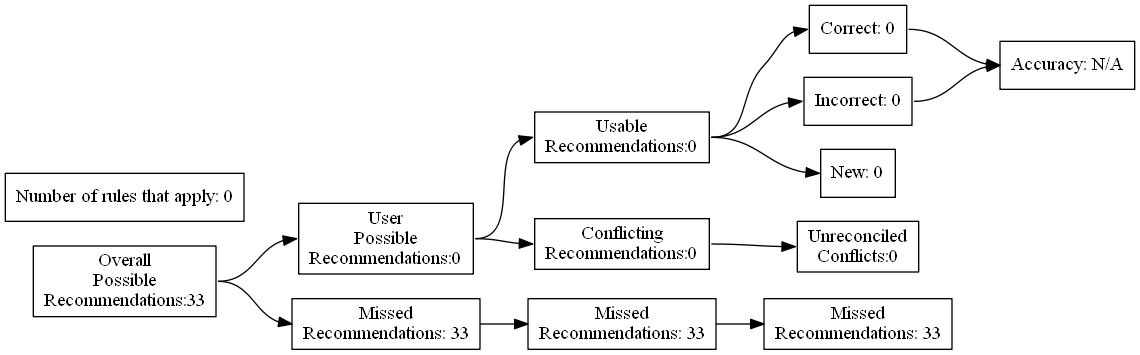

Test transaction 2 of 114 results:


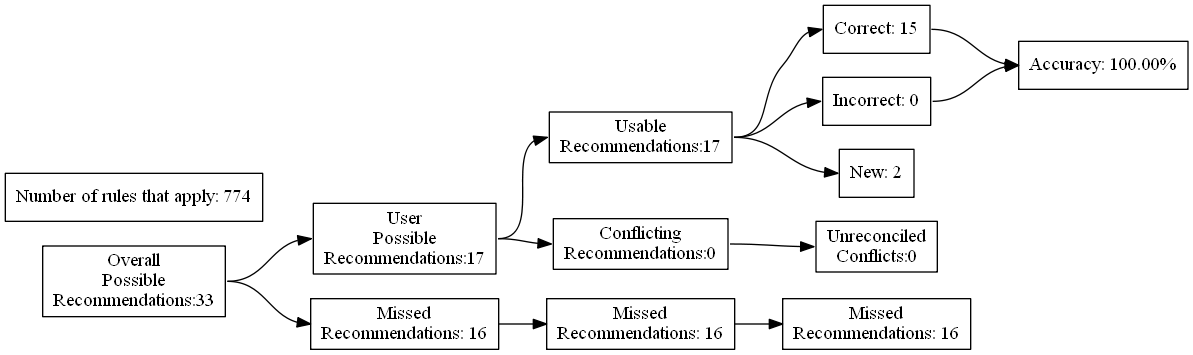

Test transaction 3 of 114 results:


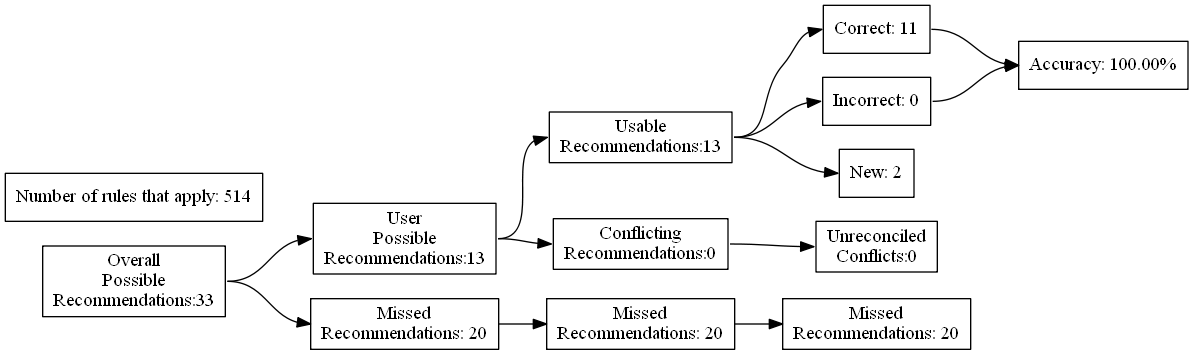

Test transaction 4 of 114 results:


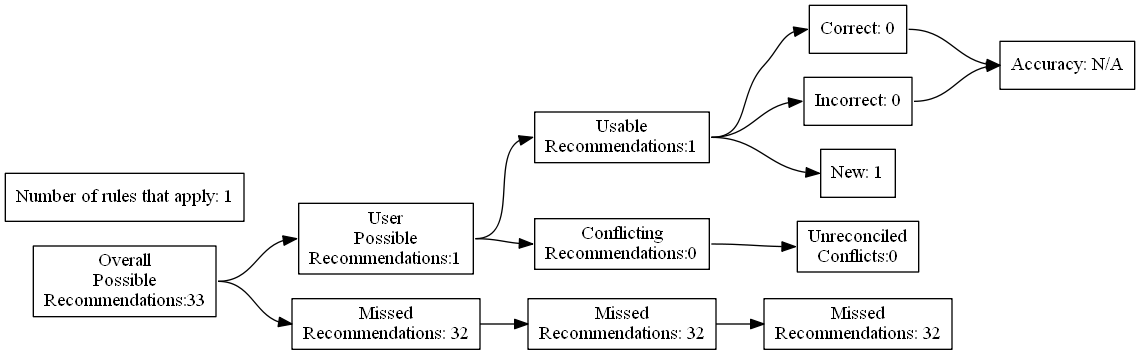

Test transaction 5 of 114 results:


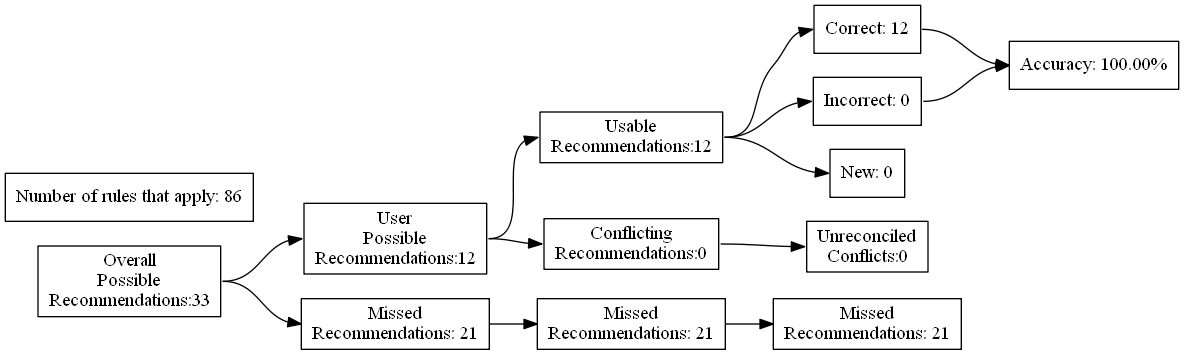

Test transaction 6 of 114 results:


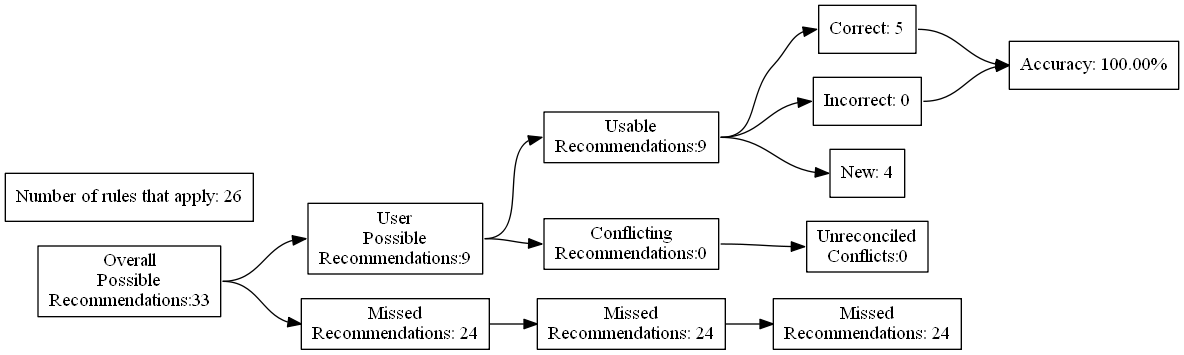

Test transaction 7 of 114 results:


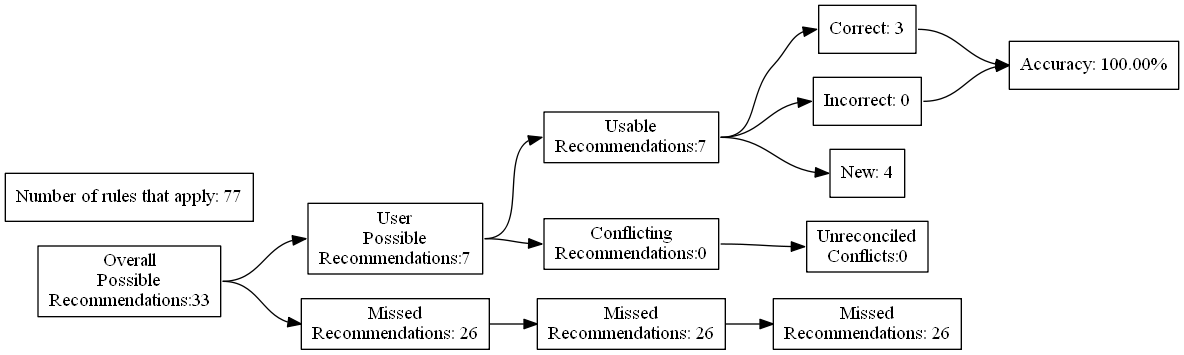

Test transaction 8 of 114 results:


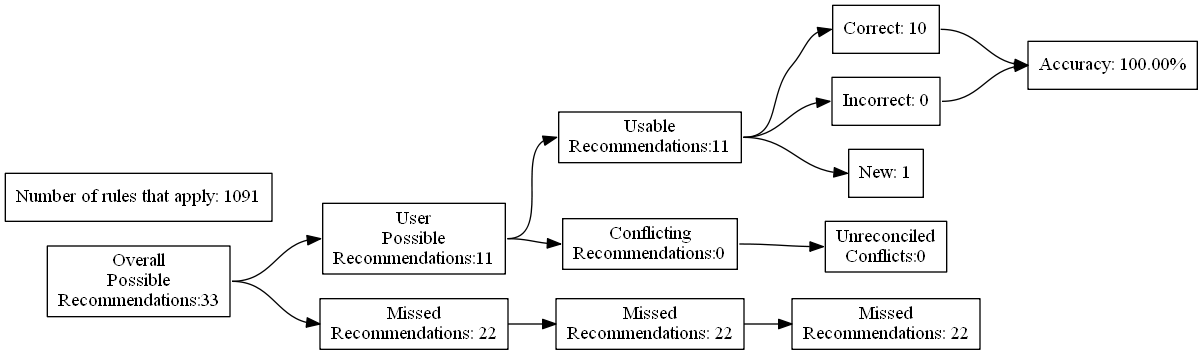

Test transaction 9 of 114 results:


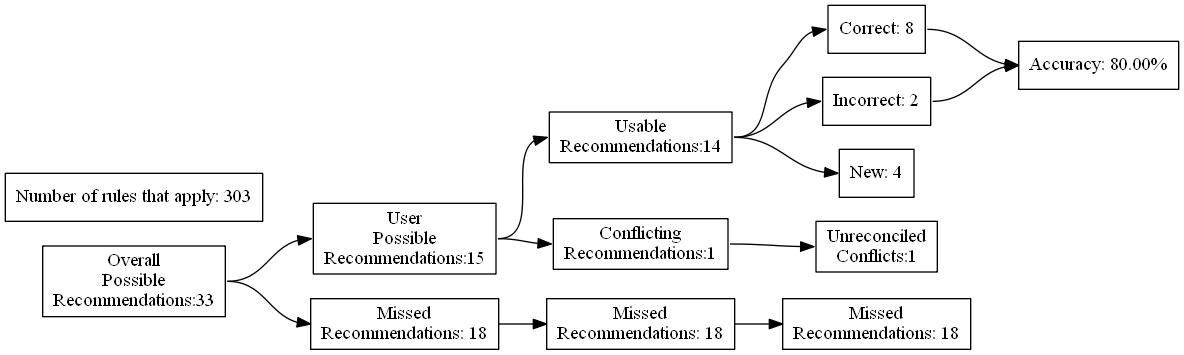

Test transaction 10 of 114 results:


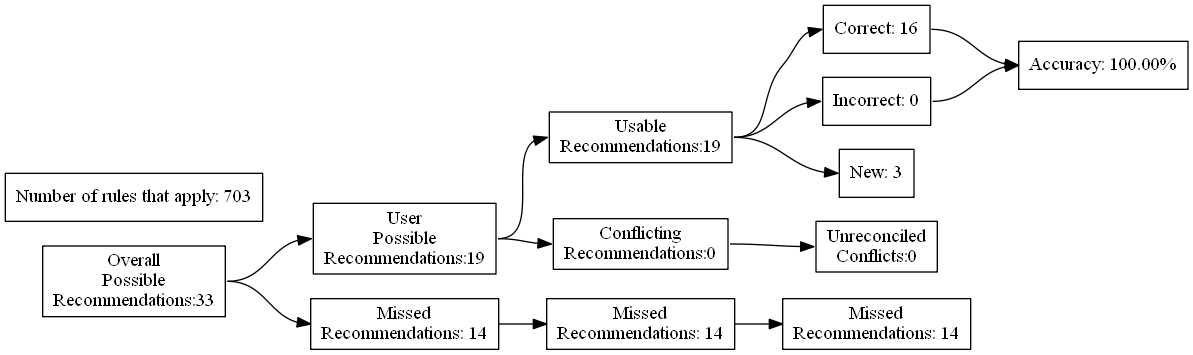

Test transaction 11 of 114 results:


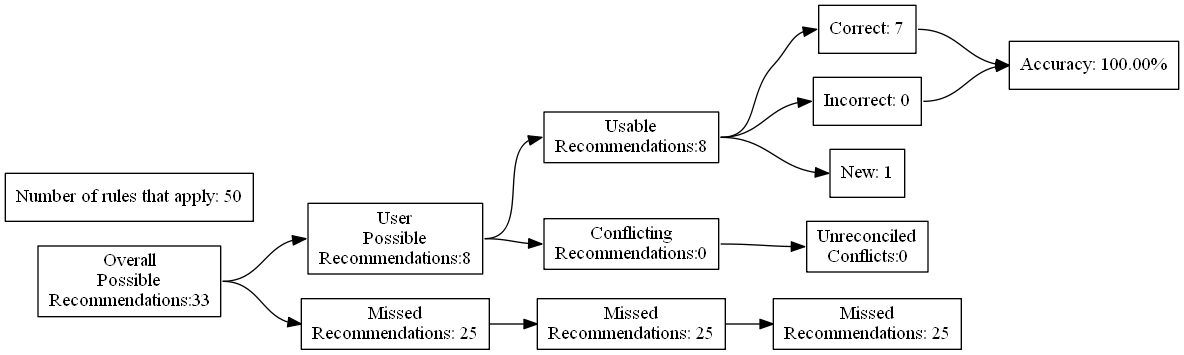

Test transaction 12 of 114 results:


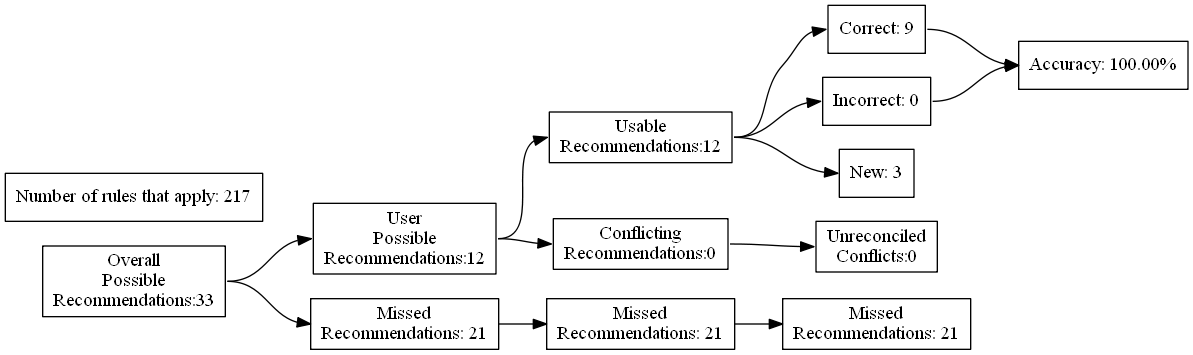

Test transaction 13 of 114 results:


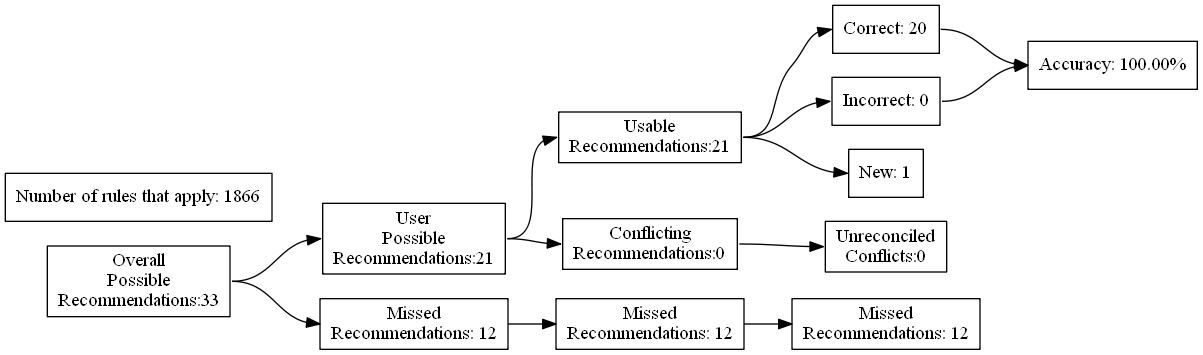

Test transaction 14 of 114 results:


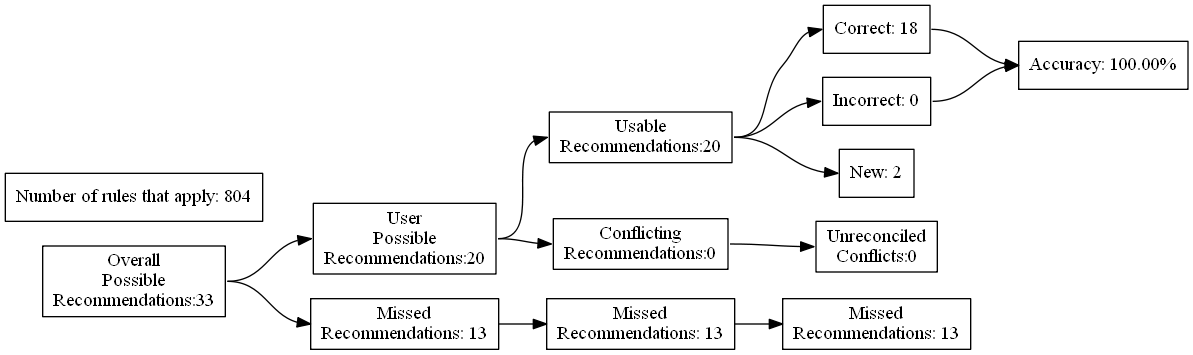

Test transaction 15 of 114 results:


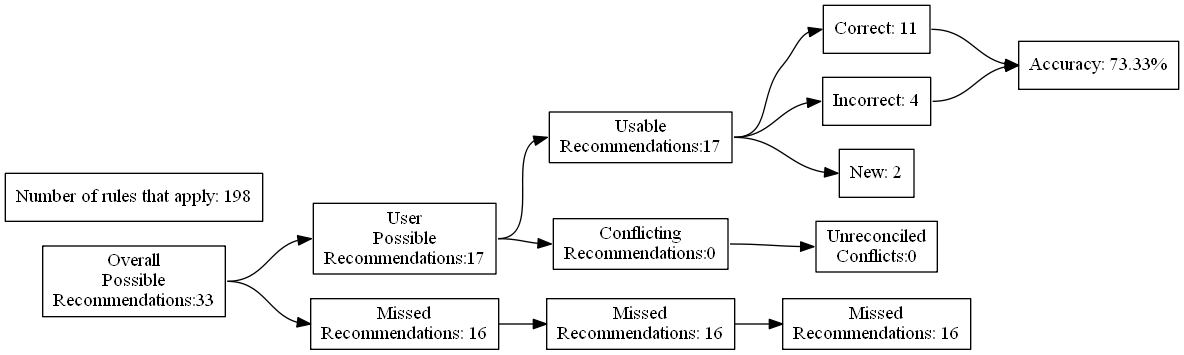

Test transaction 16 of 114 results:


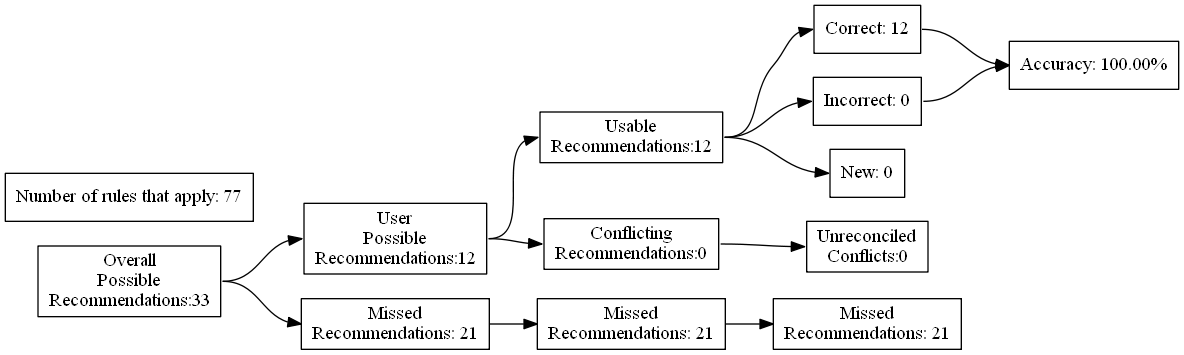

Test transaction 17 of 114 results:


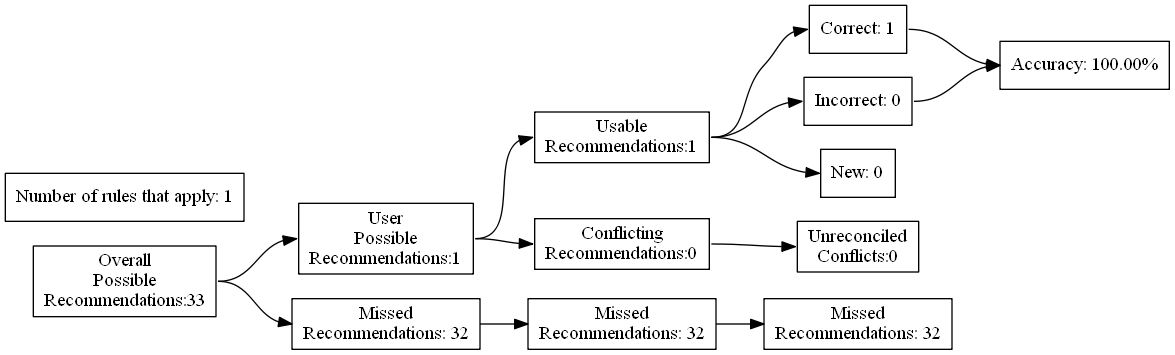

Test transaction 18 of 114 results:


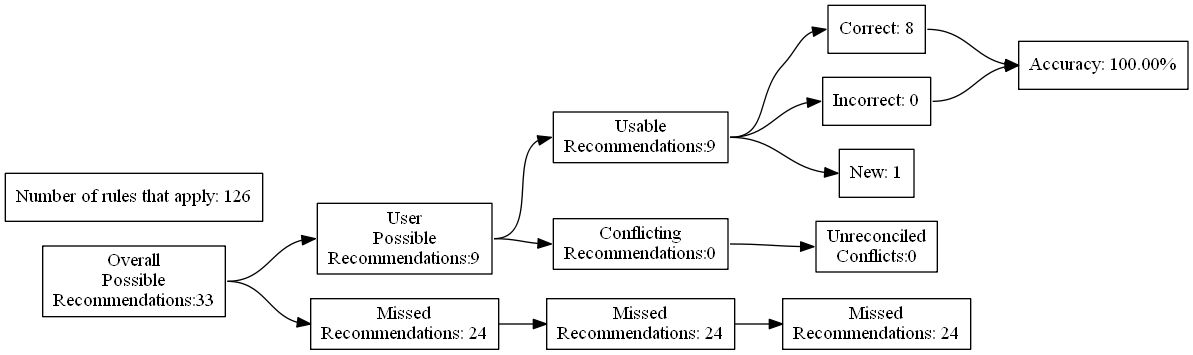

Test transaction 19 of 114 results:


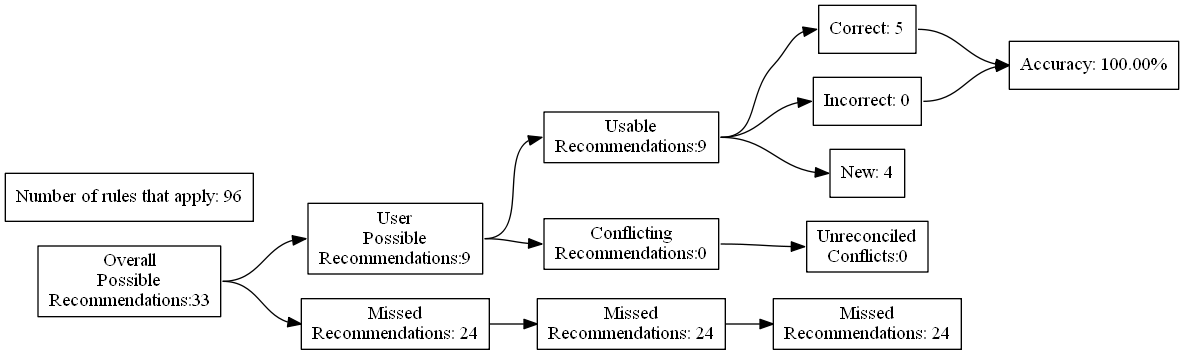

Test transaction 20 of 114 results:


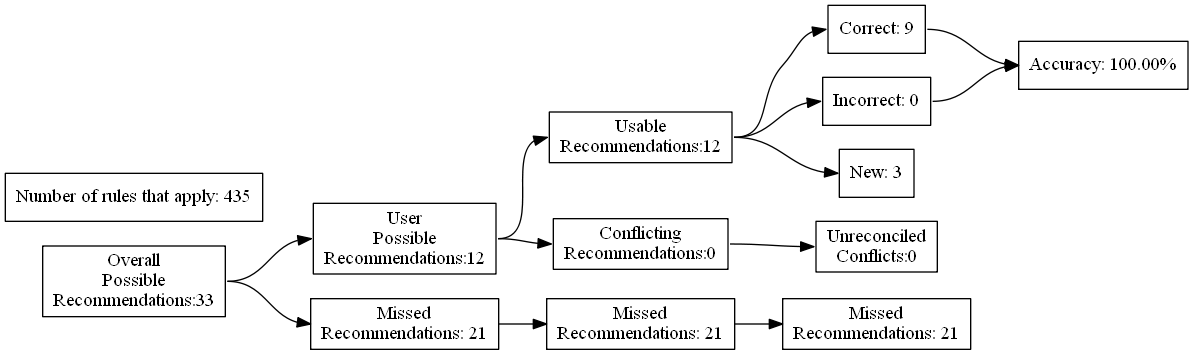

Test transaction 21 of 114 results:


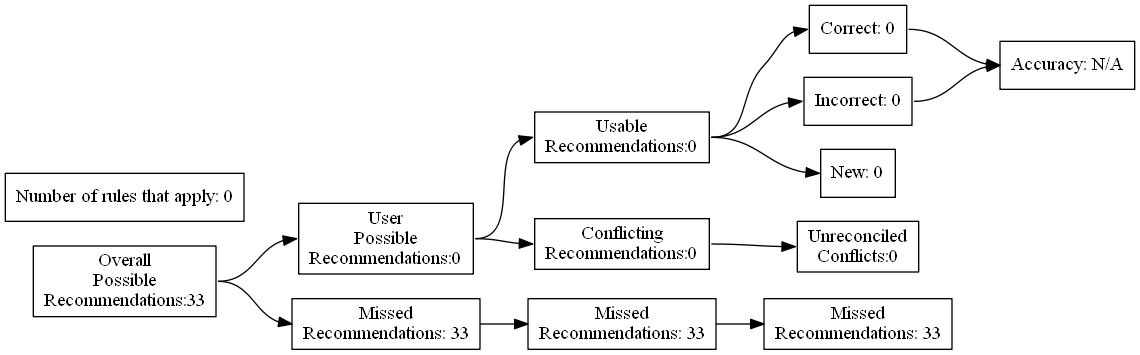

Test transaction 22 of 114 results:


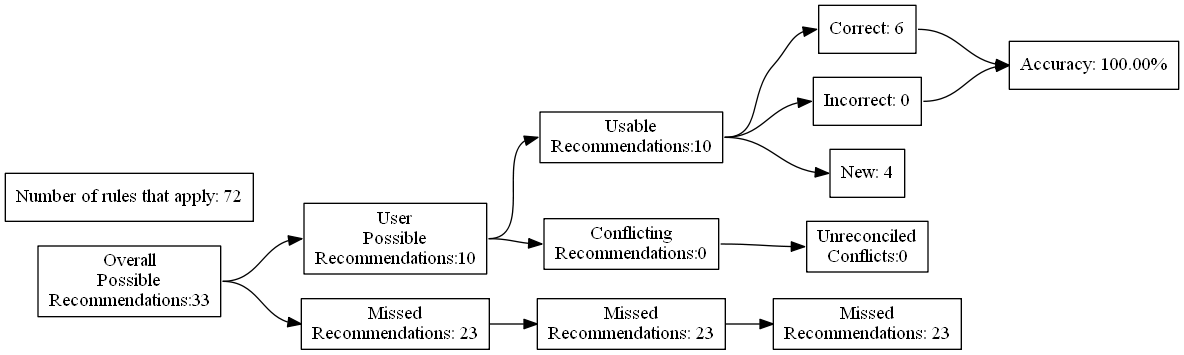

Test transaction 23 of 114 results:


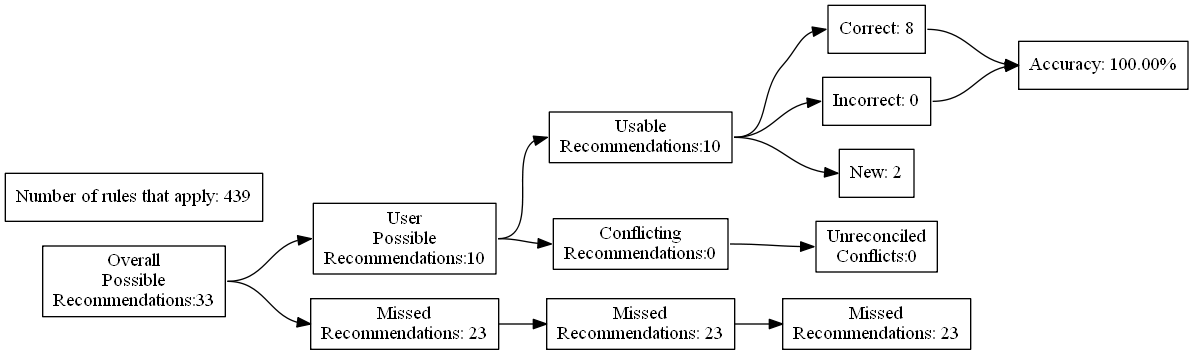

Test transaction 24 of 114 results:


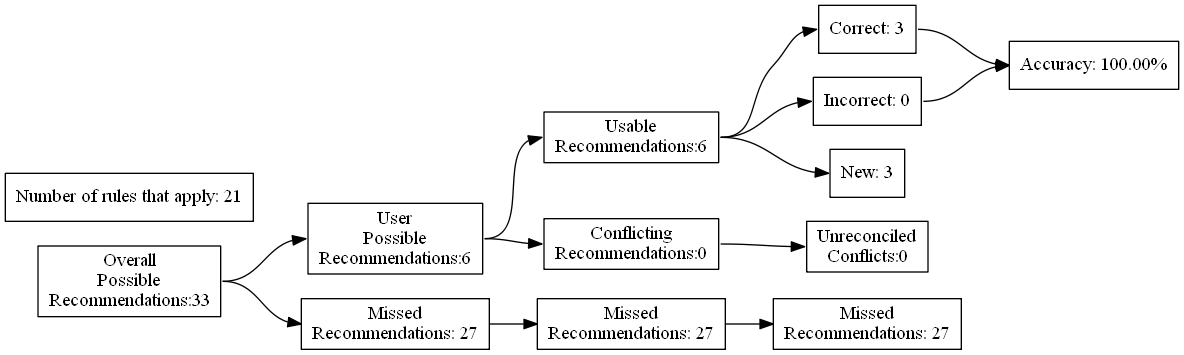

Test transaction 25 of 114 results:


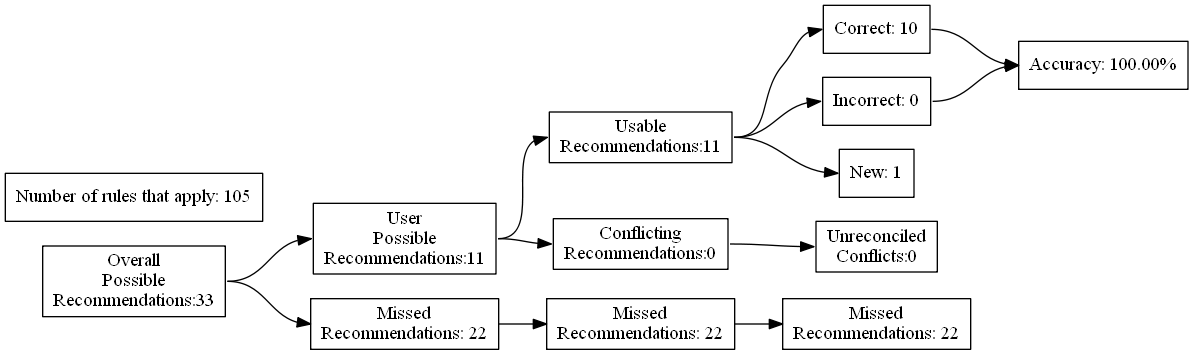

Test transaction 26 of 114 results:


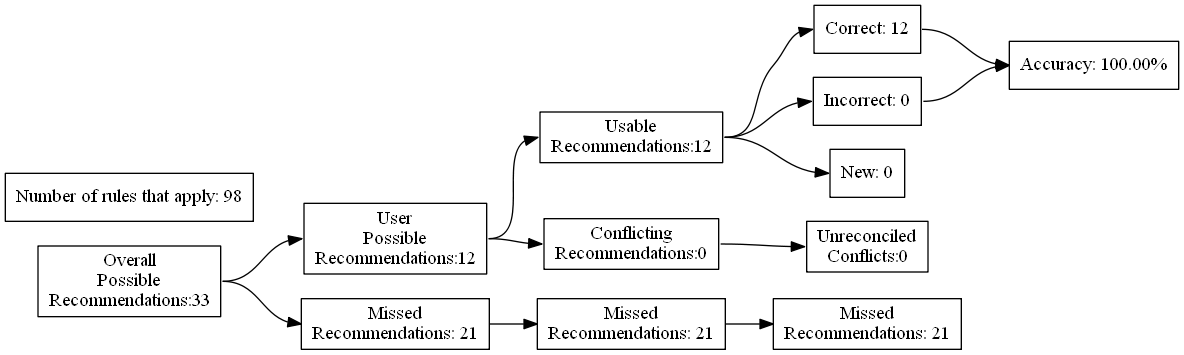

Test transaction 27 of 114 results:


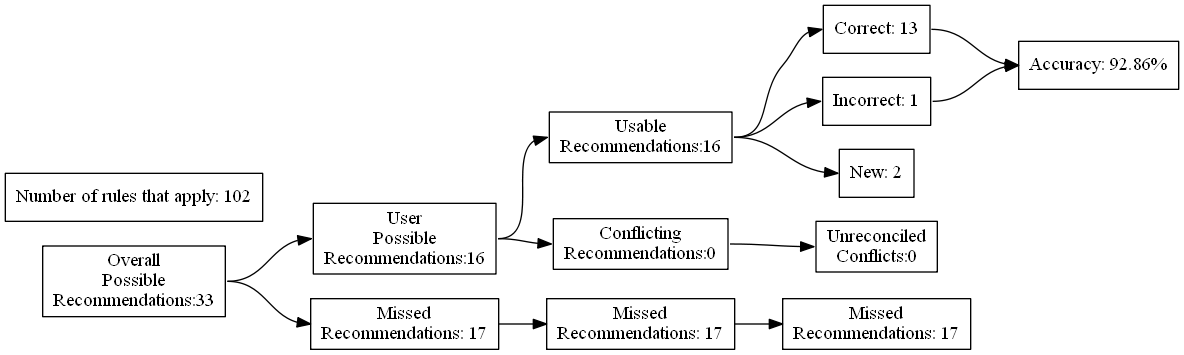

Test transaction 28 of 114 results:


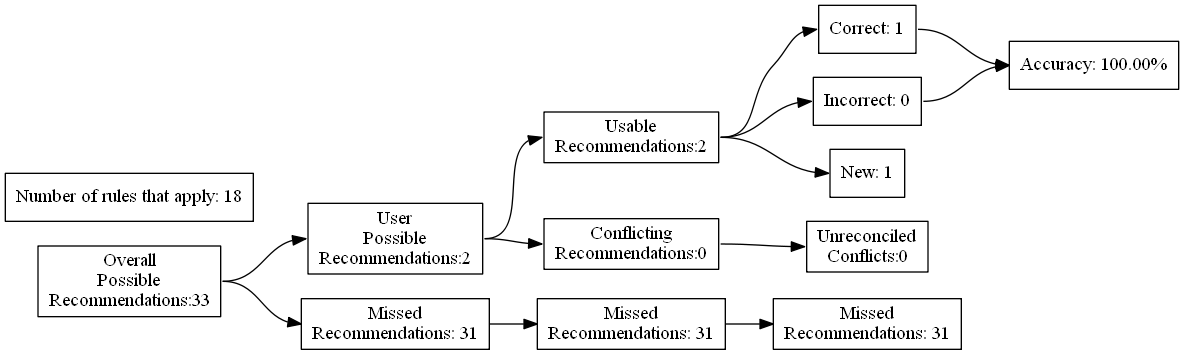

Test transaction 29 of 114 results:


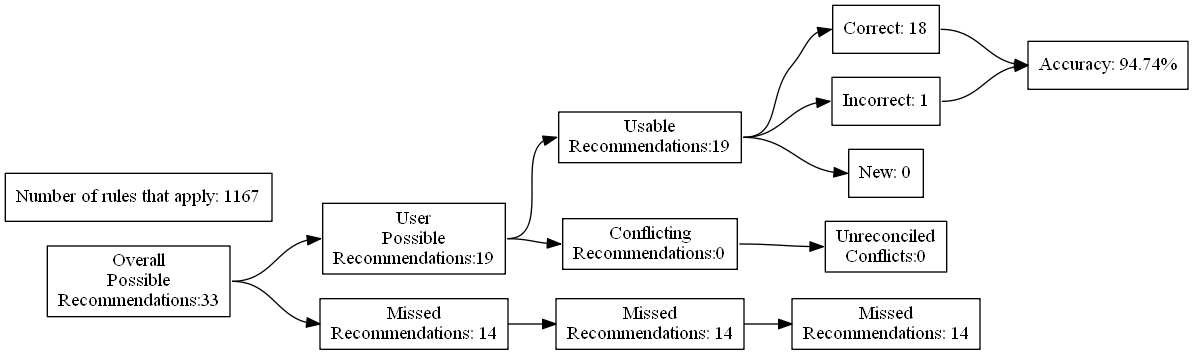

Test transaction 30 of 114 results:


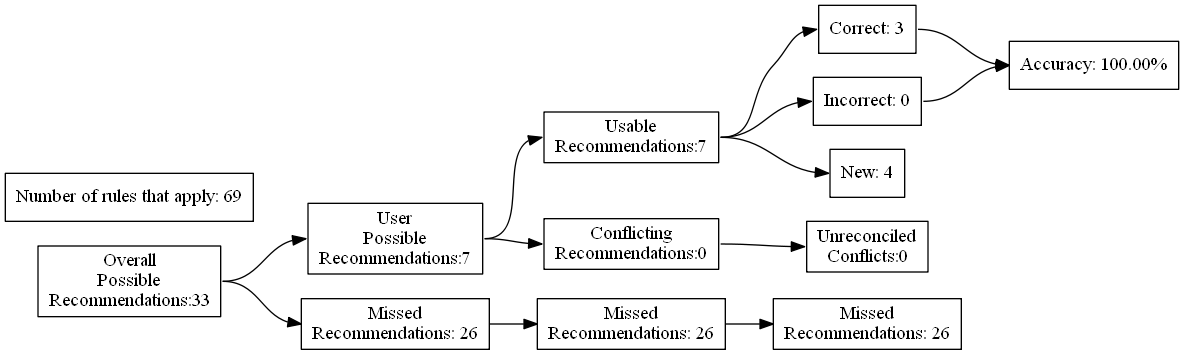

Test transaction 31 of 114 results:


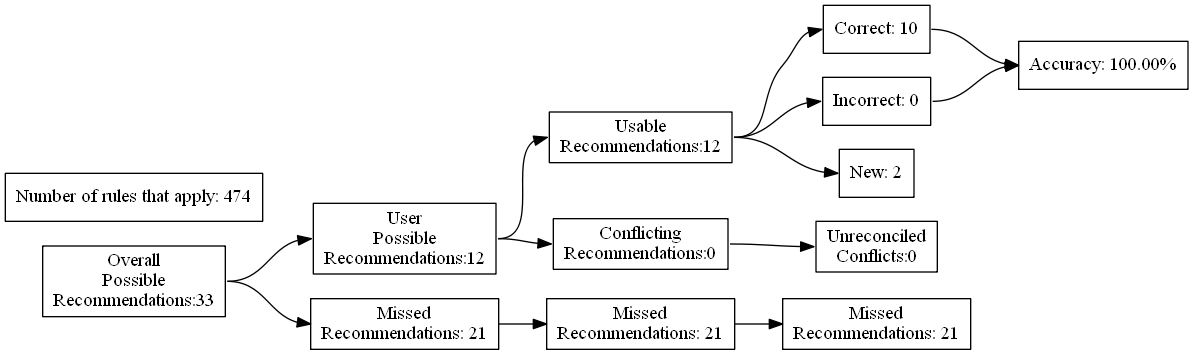

Test transaction 32 of 114 results:


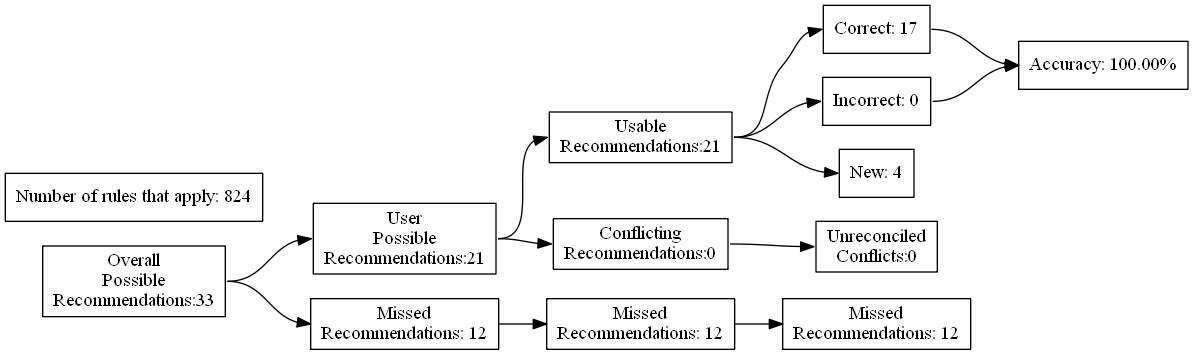

Test transaction 33 of 114 results:


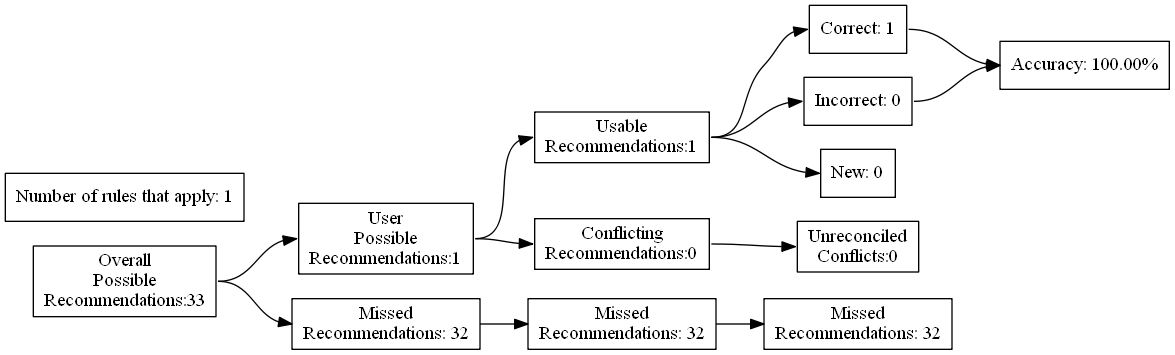

Test transaction 34 of 114 results:


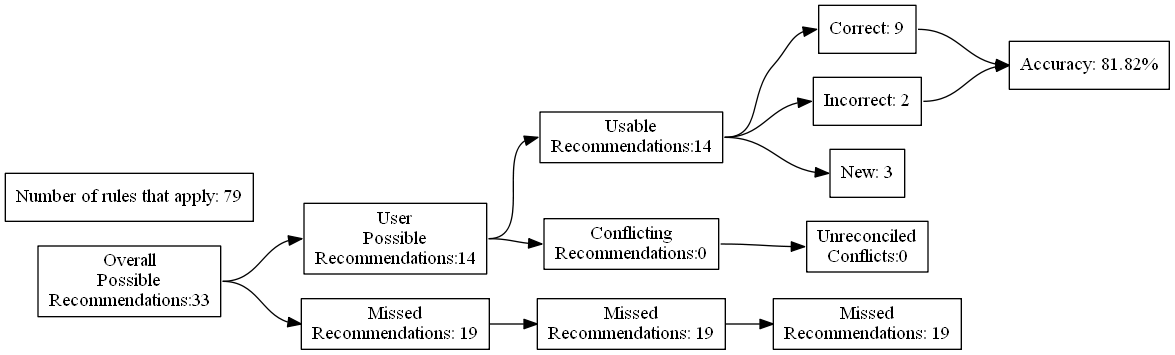

Test transaction 35 of 114 results:


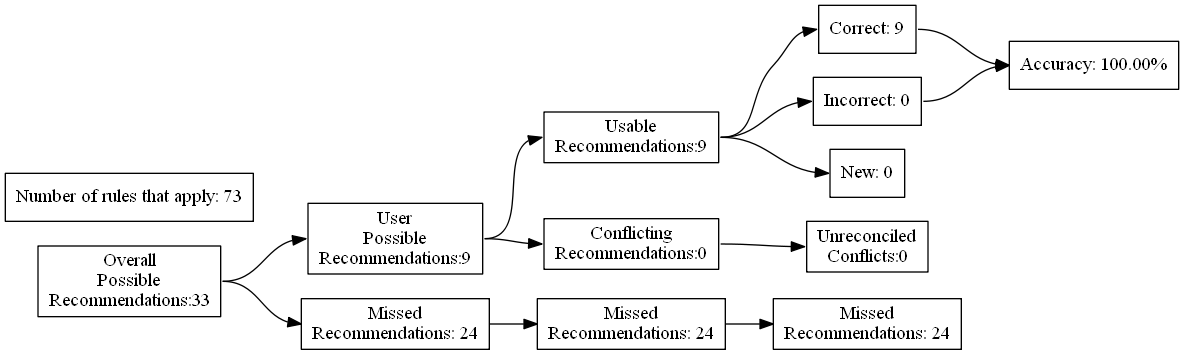

Test transaction 36 of 114 results:


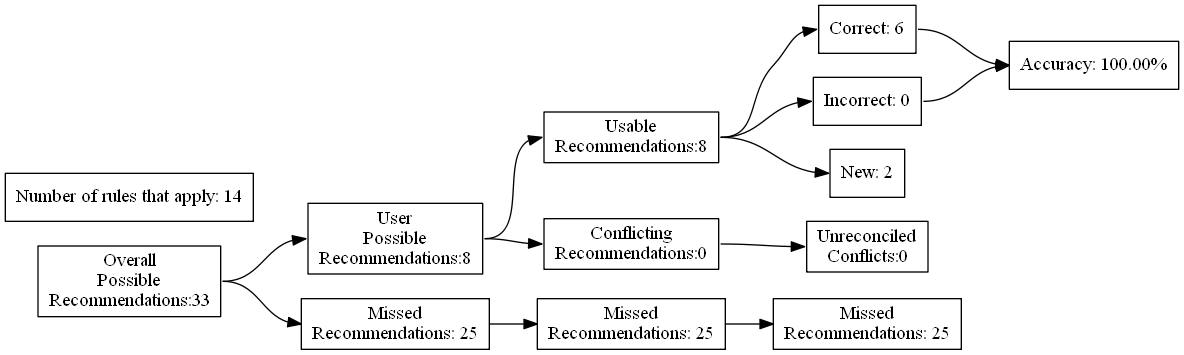

Test transaction 37 of 114 results:


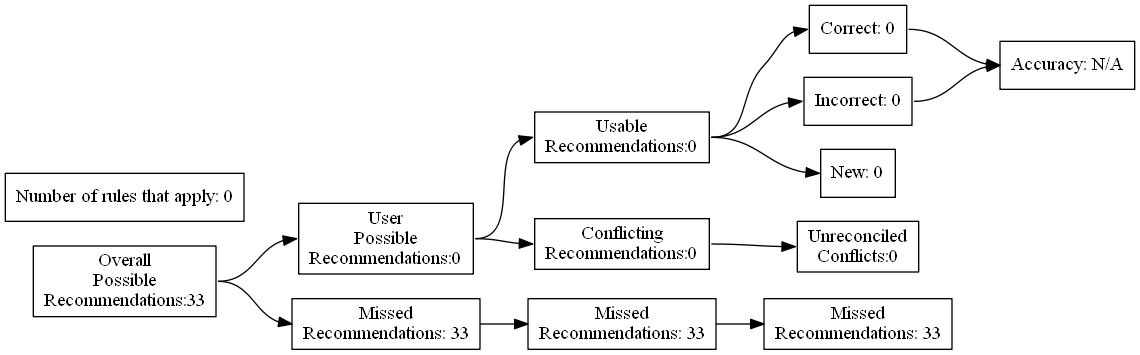

Test transaction 38 of 114 results:


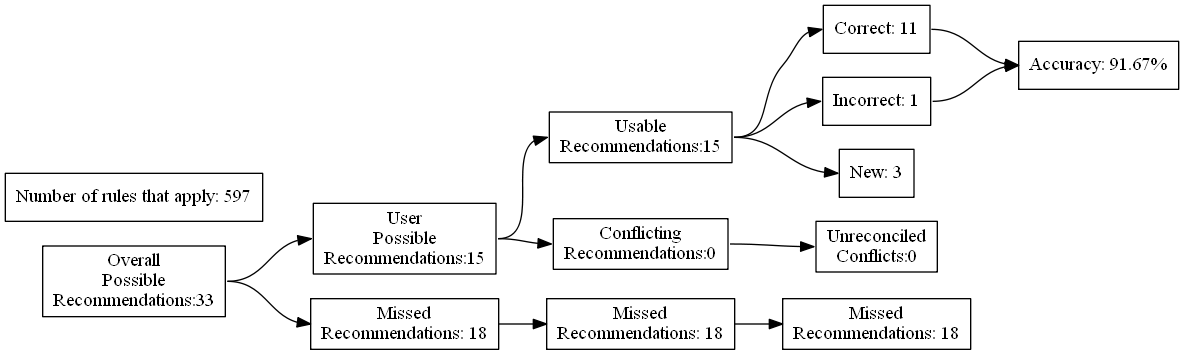

Test transaction 39 of 114 results:


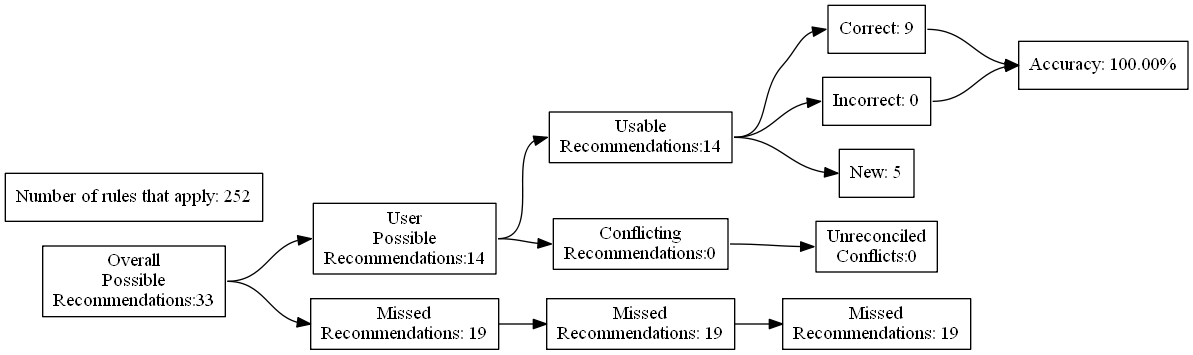

Test transaction 40 of 114 results:


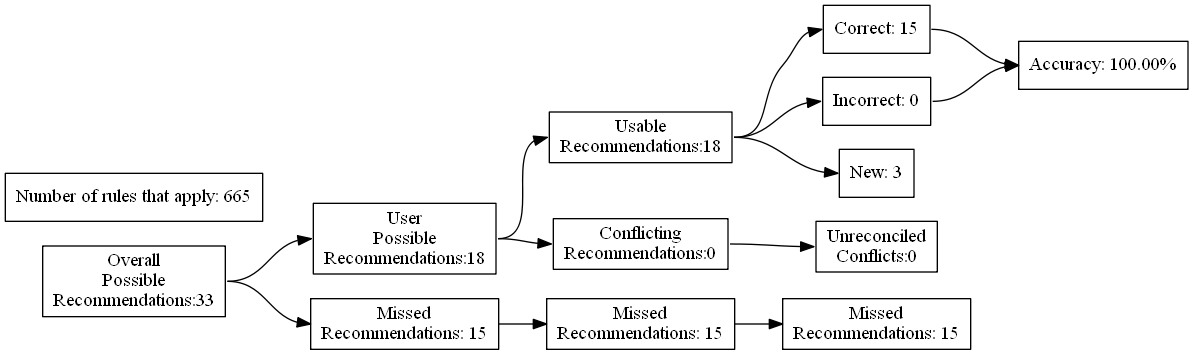

Test transaction 41 of 114 results:


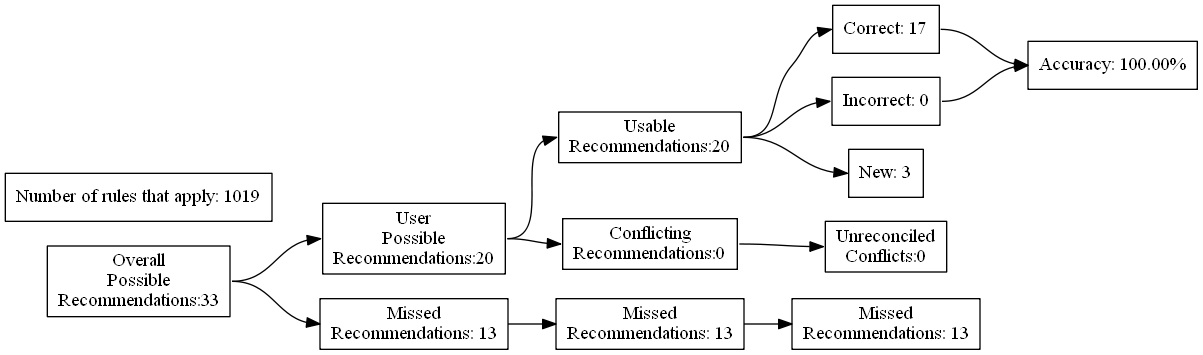

Test transaction 42 of 114 results:


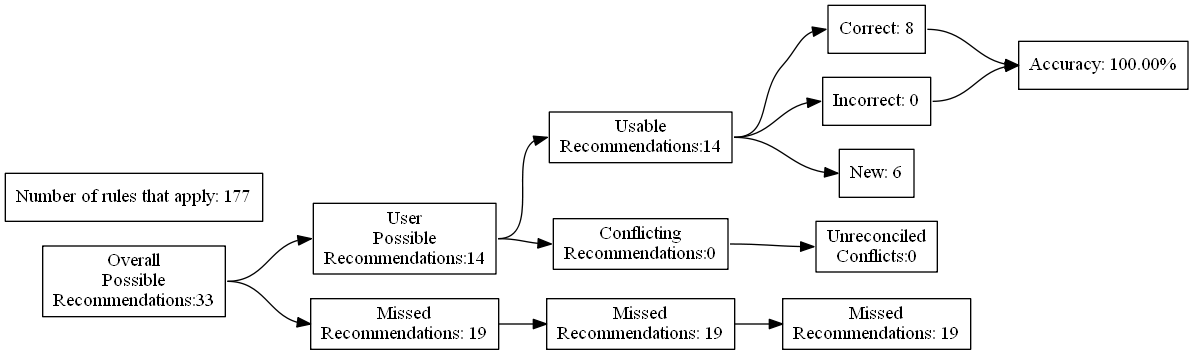

Test transaction 43 of 114 results:


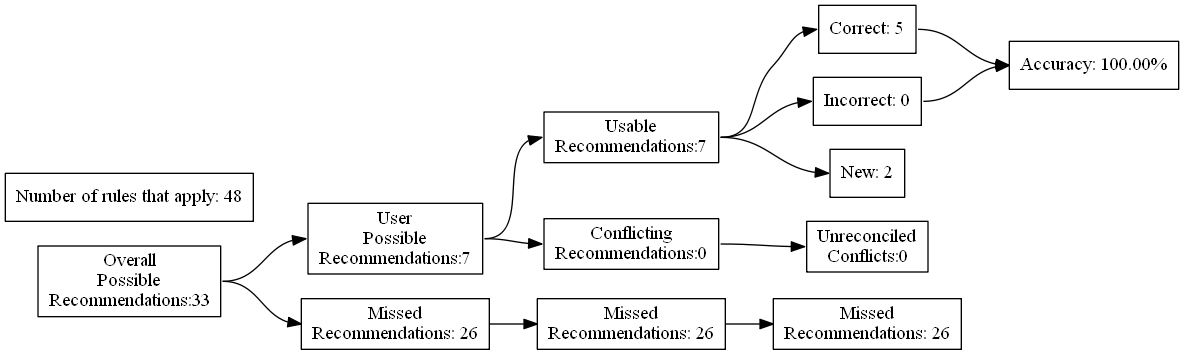

Test transaction 44 of 114 results:


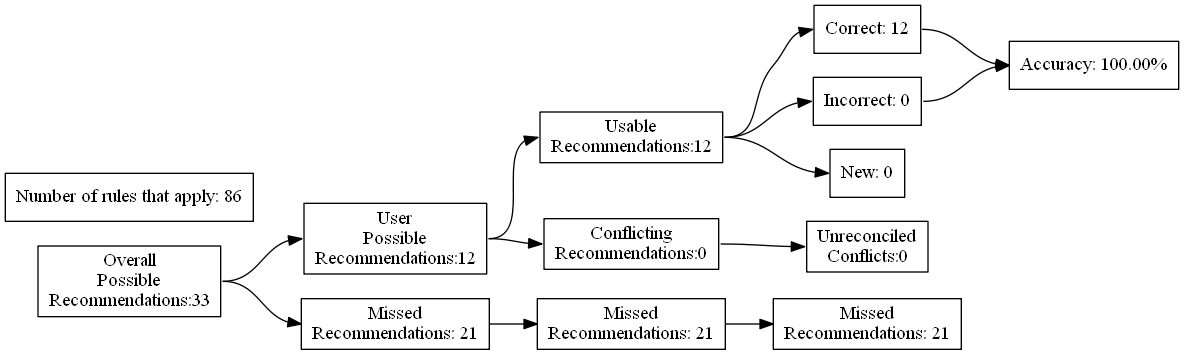

Test transaction 45 of 114 results:


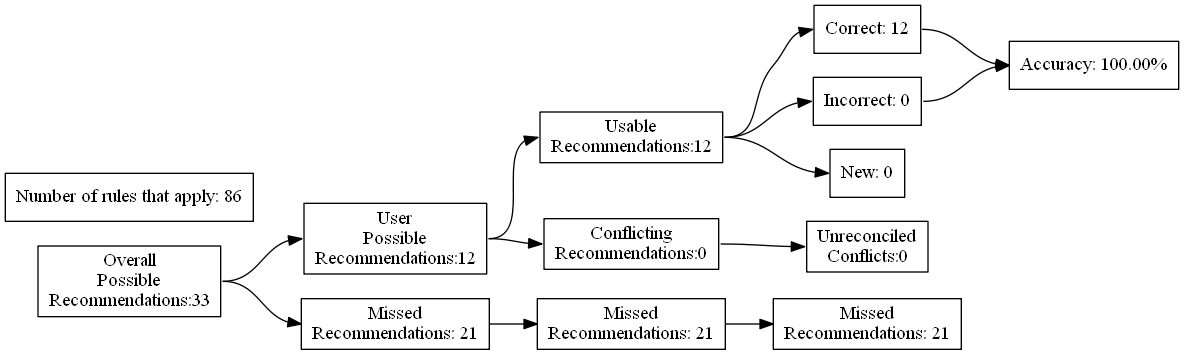

Test transaction 46 of 114 results:


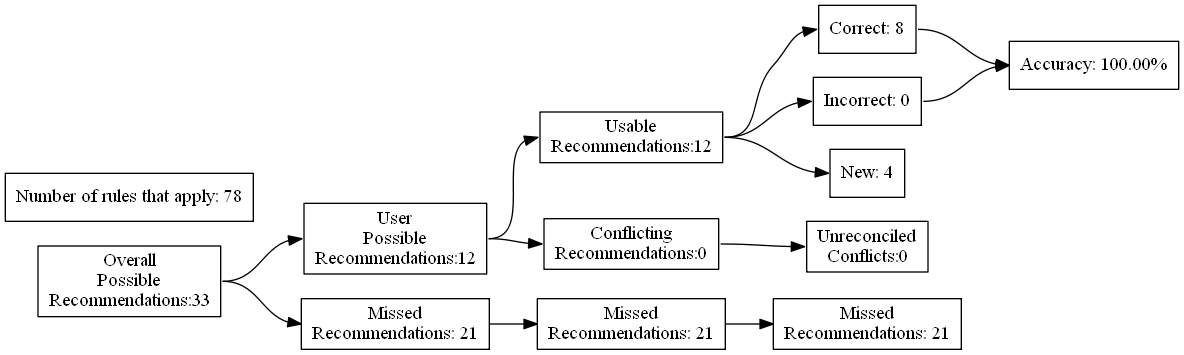

Test transaction 47 of 114 results:


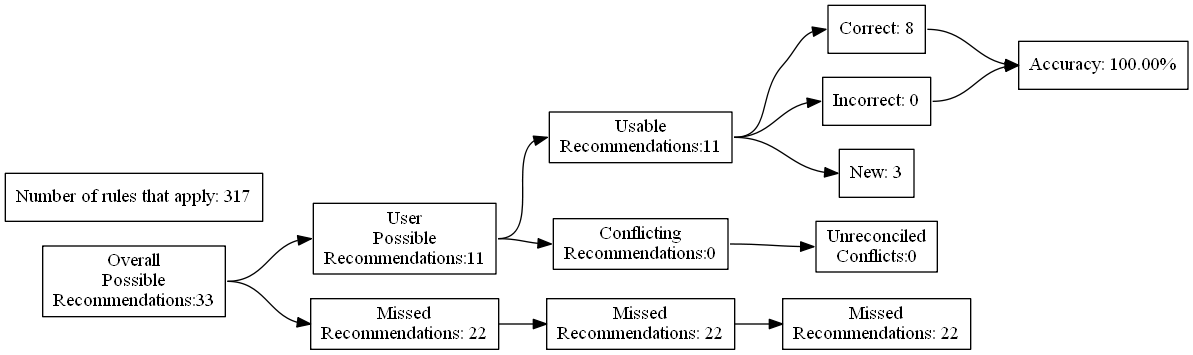

Test transaction 48 of 114 results:


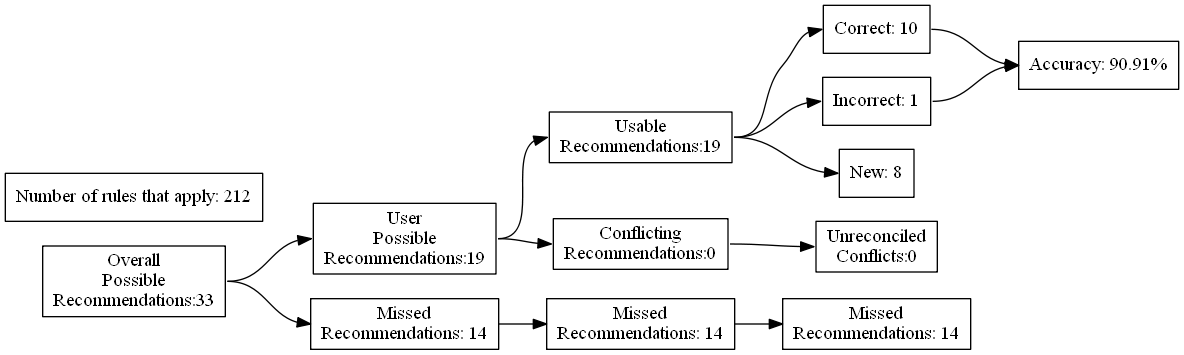

Test transaction 49 of 114 results:


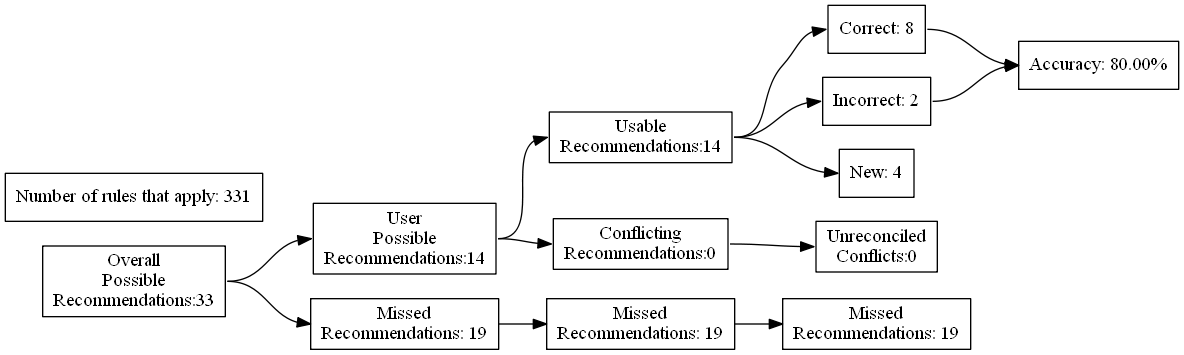

Test transaction 50 of 114 results:


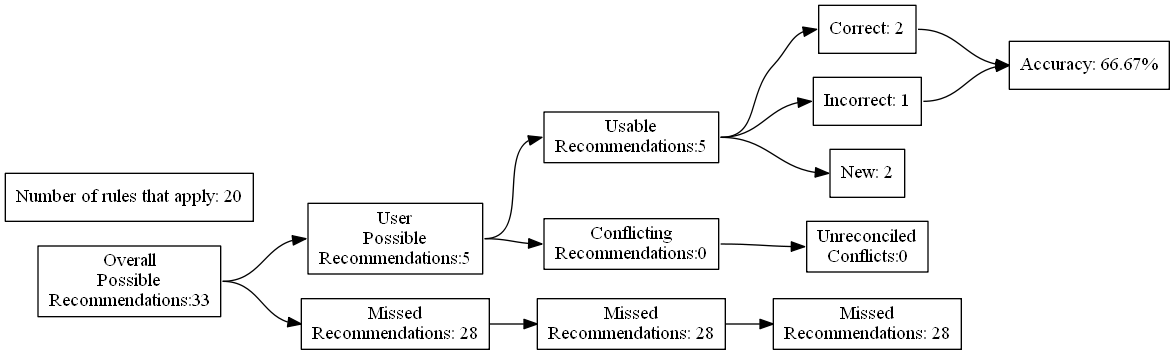

Test transaction 51 of 114 results:


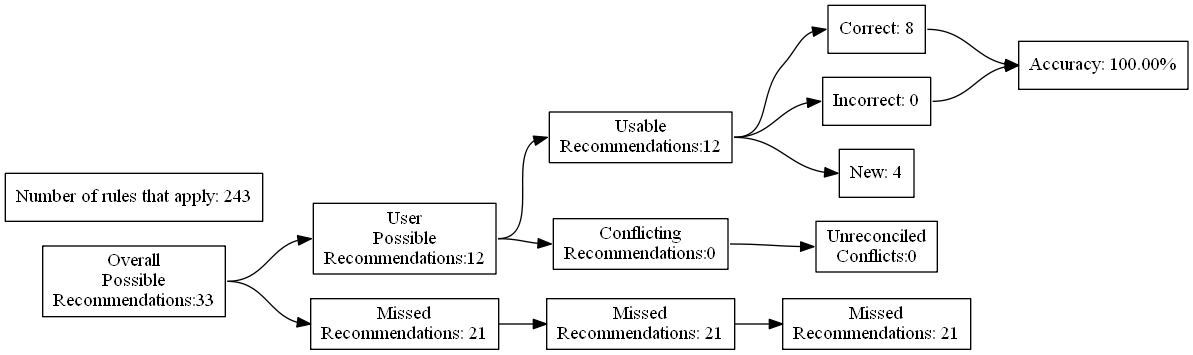

Test transaction 52 of 114 results:


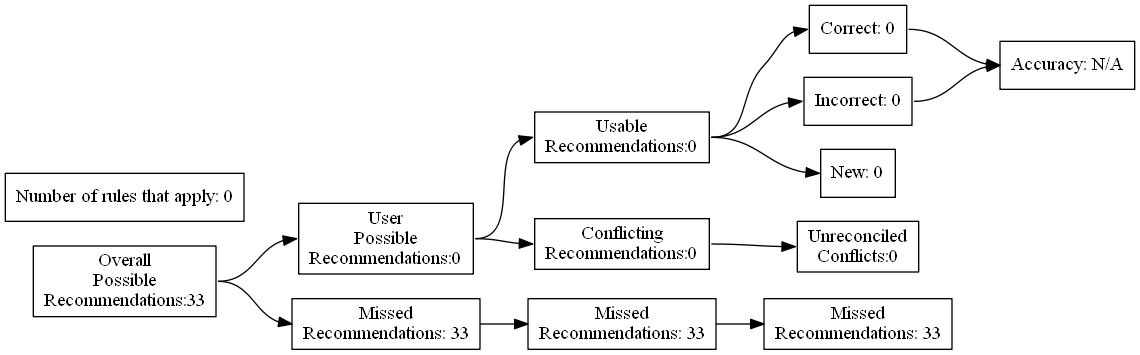

Test transaction 53 of 114 results:


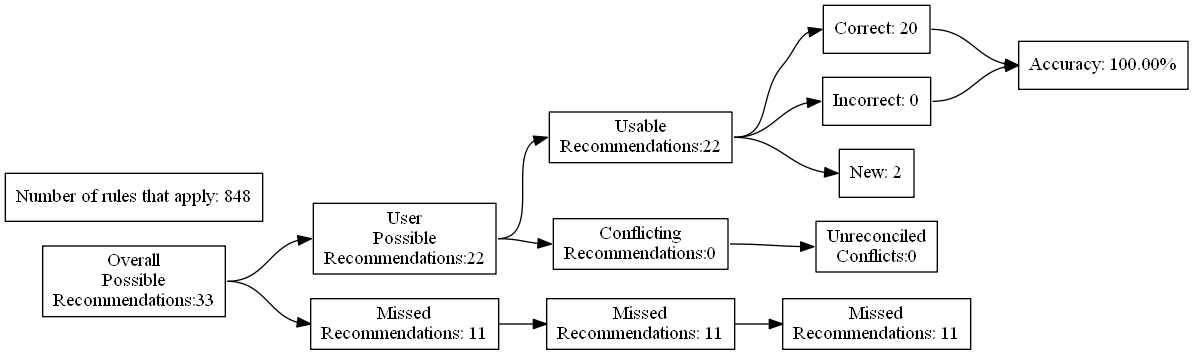

Test transaction 54 of 114 results:


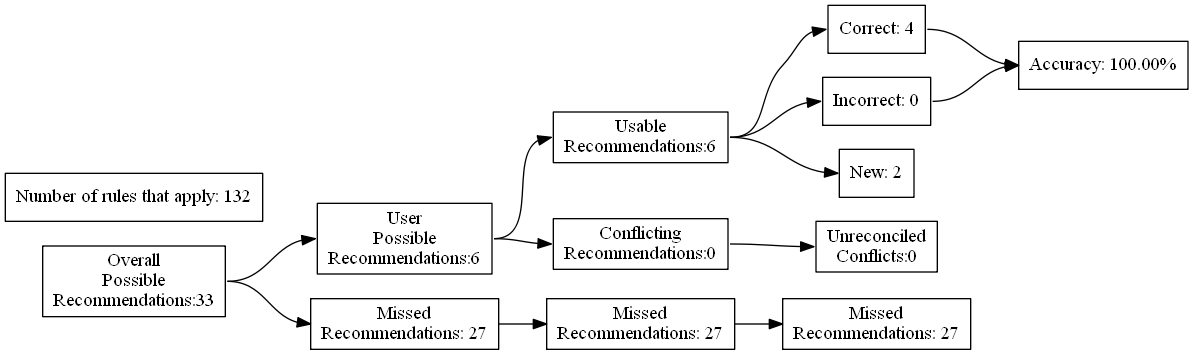

Test transaction 55 of 114 results:


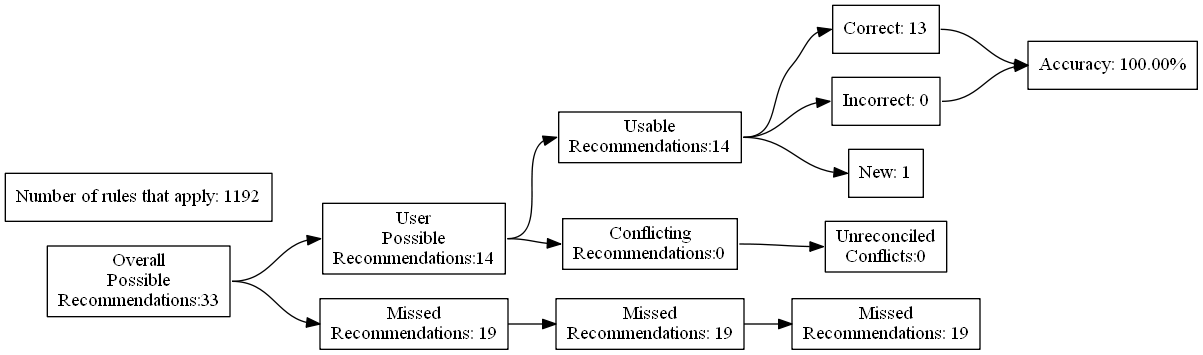

Test transaction 56 of 114 results:


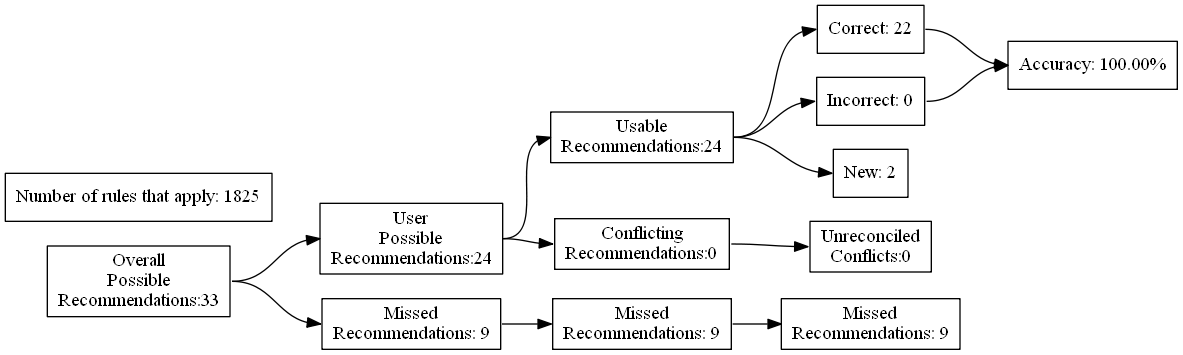

Test transaction 57 of 114 results:


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [31]:
%%time

for imageName in graph_list:
    print('Test transaction {} of {} results:'.format(''.join(filter(str.isdigit, imageName)), len(graph_list)))
    display(Image(filename=imageName))

In [32]:
# todo add hover for each that shows foods; also center trees vertically?

Our cross validation accuracy reflects an assessment of the accuracy of the interestingness parameters (i.e. interestingness of interestingness). I.e. how useful the rules generated for the parameters used for our training set are. From here we have a few options of how to assess our results: 
1. Compare our accuracy (we want to find accuracy for the average person, not average accuracy) to our confidence threshold will tell us how accuracte we've been using out rules overall (perhaps using a t-test or equivalent).
2. For "wrong" rules in our test, find commonly wrong rules and remove them from the main dataset while we investigate them further.
3. Compare the results of multiple runnings of our train/test datasets looking for variations in output (accuracy and rules).
4. Run a second order interestingness filter to confirm that our rules still belong.

We will initially just take the first three approaches, but revisit option four later.

In [33]:
# todo run cross validation 10 times and check average accuracy

After running our test 10 times with random train and test sets, and now that we've confirmed validity and identified several rules to be wary of in our final dataset, we will go back and use all of our data:

## Building the Full Model

Length of data set:  570
Number of rules:  1645
Bytes of memory used:  239102 



Consequent  \
                                   
0                           Beef   
1                         Butter   
2                        Carrots   
3                  Cheese - Hard   
4                        Chicken   
5                    Chicken Egg   
6               Chocolate - Milk   
7                            Cod   
8                         Garlic   
9                          Lemon   
10                          Lime   
11             Melon, Cantaloupe   
12               Melon, Honeydew   
13                         Peach   
14               Potatoes, White   
15                   Raspberries   
16                   Rice, White   
17                        Salmon   
18                  Strawberries   
19                          Tuna   
20                        Turkey   
21                    not Almond   
22              not Blackberries   
23                   not Cashews   
24                      not Lime   
25                 not Nectarine   
26                    not Orange   
27  not Orange Juice (with bits)   
28                   not Peanuts   
29                     not Plums   
30                   not Raisins   
31               not Raspberries   
32                 not Tangerine   

                                          Antecedents Support (Count)       \
                                             <lambda>            amin mean   
0                             [(Lamb, Pork, Chicken)]              90   90   
1   [(Cheese - Soft, Potatoes, White, Chicken), (C...              86   89   
2   [(Sweet Potato, Salmon, Tuna, Potatoes, White)...              86   93   
3   [(Cheese - Other, Chicken), (Cheese - Other, P...              87   92   
4   [(Cod, Potatoes, White), (Cod, Chicken Egg), (...              86  101   
5   [(Cheese - Soft, Cheese - Hard, Potatoes, White)]              92   92   
6   [(Chocolate - White, Chicken), (Chocolate - Wh...              87   93   
7   [(Tuna, Turkey, Chicken Egg, Potatoes, White, ...              86   95   
8               [(Onions, Basil), (Broccoli, Onions)]              86   90   
9   [(Lime, Chicken), (Lime, Potatoes, White), (Li...              86   95   
10  [(Lemon, Rice, White, Carrots), (Lemon, Turkey...              86   92   
11  [(Melon, Honeydew, Carrots, Chicken), (Melon, ...              86   94   
12  [(Melon, Cantaloupe, Chicken), (Melon, Cantalo...              86   97   
13                         [(Lime, Nectarine, Lemon)]              87   87   
14  [(Tuna, Rice, White, Carrots, Chicken Egg), (S...              86   93   
15  [(Blackberries, Chicken), (Blackberries, Straw...              91   93   
16  [(Sweet Potato, Salmon, Cod, Potatoes, White),...              86   89   
17  [(Sweet Potato, Tuna, Rice, White, Carrots), (...              86   92   
18  [(Raspberries, Melon, Honeydew, Carrots), (Ras...              86   89   
19  [(Salmon, Cod, Chicken Egg, Chicken), (Salmon,...              86   96   
20  [(Cucumber, Tuna, Cod, Chicken), (Basil, Tuna,...              91   92   
21  [(not Cashews, not Orange Juice (with bits)), ...              86  100   
22  [(not Blueberries, not Raspberries), (not Blue...              88   94   
23  [(not Almond, not Peanuts, not Orange Juice (w...              86   99   
24  [(not Lemon, not Orange), (not Lemon, not Tang...              86   93   
25  [(not Tangerine, not Orange, not Raisins), (no...              86   91   
26  [(not Nectarine, not Orange Juice (with bits))...              86   91   
27  [(not Orange Juice (without bits), not Orange)...              95   99   
28  [(not Almond, not Raisins), (not Tangerine, no...              86   99   
29  [(not Nectarine, not Tangerine, not Raisins), ...              86   88   
30  [(not Raspberries, not Peanuts), (not Cherries...              87   88   
31              [(not Blueberries, not Blackberries)]              90   90   
32  [(not Orange, not Peanuts), (not Orange, not R...              86   92   

        Confidence (%)        

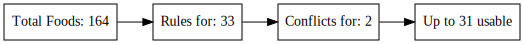

Wall time: 2.94 s


In [34]:
%%time
# Same data set we used for our train/test, but complete

model_rules_df = generate_association_rules(original_dataset_df, supp=15, conf=90)
model_rules_df.to_csv('model_association_rules.csv')  # save rules
# todo capture model_rules in db instead of csv

model_grouped_rules_df = summary_table(model_rules_df) # summary_table
display(model_grouped_rules_df)
d1, total_foods, rules_for, conflicts, overall_possible_rules = visualize_available_food_rules(original_dataset_df, model_grouped_rules_df)
display(d1)  # visualize_available_food_rules

Note that despite having more overall rules than in our training set, those rules generate a smaller set of consequents.

In [35]:
# todo create summary scatterplot w/ color scale.

Our last consideration (besides building a tool for people to utilize our model and then periodically checking in on how it's doing) is to consider scalability. Association rules often have difficulty scaling both from a complexity point of view, and from "too many" rules being generated. While the interestingness parameters we chose above were manually tuned for our data, that's only for our data as it is NOW.

There are a number of papers on the topic of scalability and parameter adjustment for association rules, and we will need to review further. At initial glance, a couple of interesting ideas that popped up:

1. Propose only returning the top K rules, as presented by Fournier-Viger, Wu, and Tseng in [Mining Top-K Association Rules](http://www.philippe-fournier-viger.com/spmf/top_k_association_rules_2012.pdf)(in their case, as measured by Support; continuinig on solutions referenced in their paper). While potentially useful in many cases, this method wouldn't help in our case. We want to maximize the possibility of giving a "good" recommendation to survey participants, and we can't do that if we cut [a potentially large] set of useful rules. 
2. Use functions to scale our parameters as the number of transactions increase. Fournier-Viger gives an exponential decay function for the support threshold [here](http://data-mining.philippe-fournier-viger.com/how-to-auto-adjust-the-minimum-support-threshold-according-to-the-data-size/), which while not necessarily useful for solving the problem of scaling to very large size, presents a dynamic parameter adjustment method that may be useful.

For now, we will postpone addressing this potential issue until it arises.

## IBDalizer (Predictive User Tool)

In [36]:
#tool for people
# take input -- in iterable form (currently takes lists, but tuples would work)
# rules = generate_applicable_rules
# turn yielded rules into a dataframe
# remove conflicts
# summary_table
# generate more user-friendly recommendations